In [1]:
from utils.load_results import *
from utils.plot_helpers import *
from utils.table_reps import *
from utils.concept_reps import *
from utils.analysis_from_interaction import *
from utils.prep_corpus_data import get_corpus_data

import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
plt.style.use('default')
import random
from seaborn.algorithms import bootstrap
import os

# Quantitative analyses
This notebook contains code to plot and bootstrap confidence intervals for accuracies and other metrics for both context-unaware and context-aware trained agents.
Code defaults to context-aware, context-unaware results can be loaded by setting the context-unaware flag.

In [2]:
datasets = ['(3,4)', '(3,8)', '(3,16)', '(4,4)', '(4,8)', '(5,4)']
n_values = [4, 8, 16, 4, 8, 4]
n_attributes = [3, 3, 3, 4, 4, 5]
n_epochs = 0
n_runs = 5
n_datasets = len(datasets)
paths = ['results/' + d + '_game_size_10_vsf_0' for d in datasets]

In [3]:
context_unaware = True # whether original or context_unaware simulations are evaluated
length_cost = True # whether length_cost was applied
early_stopping = True
hierarchical = False
shared_context = True
rsa = True
rsa_test = 'testtrainmixed' # use 'test_load_train' (and 'testtrain' for use with interactions) for RSA setting where RSA tests have been done on training utterances and test datasets, use 'test' for RSA setting where testing was done on test utterances and test dataset
test = 'test'
rsa_test_int = 'testtrainmixed' # use 'testtrain' if rsa_test == 'test_load_train' else use same as rsa_test
if length_cost:
    if context_unaware:
        setting = 'length_cost/context_unaware'
    elif not context_unaware:
        setting = 'length_cost/context_aware'
else:
    if context_unaware:
        setting = 'context_unaware'
    else:
        setting = 'standard'
if hierarchical:
    setting = setting + "/hierarchical"
if shared_context:
    setting = setting + "/shared_context"

In [4]:
# get n_epochs if early stopping
if early_stopping:
    
    n_epochs = []
    for d in range(len(datasets)):
        
        for run in range(n_runs):
    
            path_to_run = paths[d] + '/' + str(setting) +'/' + str(run) + '/' 
            with open(os.path.join(path_to_run, 'loss_and_metrics.pkl'), 'rb') as input_file:
                data = pickle.load(input_file)
                final_epoch = max(data['loss_train'].keys())
                n_epochs.append(final_epoch)
                
if rsa:
    n_epochs = 0
            

## Accuracies

In [5]:
all_accuracies = load_accuracies(paths, n_runs=n_runs, n_epochs=0, val_steps=1, zero_shot=False, context_unaware=context_unaware, length_cost=length_cost, early_stopping=early_stopping, hierarchical=hierarchical, shared_context=shared_context, rsa=rsa, rsa_test='test')

### Final accuracies 
Final accuracies heatmap plot + get accuracy means and sds for table representation.

In [6]:
rsa_test_accuracies = all_accuracies['rsa_test_acc']
test_accuracies = all_accuracies['final_test_acc']
rsa_test_gen_utt = all_accuracies['rsa_test_gen_utt_acc'] # only feasible for smallest dataset (and restricted message length)

In [7]:
results = np.apply_along_axis(calc_mean_std, 1, test_accuracies)
df_test = pd.DataFrame(results, columns=['test'])
df_test.index = datasets

results = np.apply_along_axis(calc_mean_std, 1, rsa_test_accuracies)
df_rsa = pd.DataFrame(results, columns=['rsa test'])
df_rsa.index = datasets

df_merged = pd.concat([df_test, df_rsa], ignore_index=False, axis=1)
latex_table = df_merged.to_latex()
print(latex_table)

\begin{tabular}{lll}
\toprule
{} &         test &     rsa test \\
\midrule
(3,4)  &  0.79 ± 0.02 &  0.87 ± 0.04 \\
(3,8)  &  0.87 ± 0.03 &  0.82 ± 0.03 \\
(3,16) &  0.95 ± 0.04 &  0.72 ± 0.03 \\
(4,4)  &  0.88 ± 0.02 &  0.75 ± 0.04 \\
(4,8)  &  0.89 ± 0.07 &  0.66 ± 0.02 \\
(5,4)  &  0.88 ± 0.09 &  0.67 ± 0.07 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_86925/3594356985.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df_merged.to_latex()


In [29]:
# go through all datasets
for i, d in enumerate(datasets):
    print(d)
    means_test_specific, means_test_generic, means_rsa_specific, means_rsa_generic = [], [], [], []
    for run in range(5):
        path_to_run = paths[i] + '/' + str(setting) +'/' + str(run) + '/'
        path_to_interaction_test = (path_to_run + 'interactions/test/epoch_0/interaction_gpu0')
        path_to_interaction_rsa = (path_to_run + 'interactions/rsa_' + rsa_test + '/epoch_0/interaction_gpu0')
        interaction_test = torch.load(path_to_interaction_test)
        interaction_rsa = torch.load(path_to_interaction_rsa)
        
        concepts_test = objects_to_concepts(interaction_test.sender_input, n_values[i])
        
        # specific and generic concepts test dataset (same as rsa dataset)
        specific_concepts_test, generic_concepts_test, specific_indices, generic_indices = [], [], [], []
        for idx, (objects, fixed) in enumerate(concepts_test):
            if sum(fixed) == n_attributes[i]:
                specific_concepts_test.append((objects, fixed))
                specific_indices.append(idx)
            if sum(fixed) == 1:
                generic_concepts_test.append((objects, fixed))
                generic_indices.append(idx)
                
        means_test_specific.append(torch.mean(interaction_test.aux['acc'][specific_indices]))
        means_test_generic.append(torch.mean(interaction_test.aux['acc'][generic_indices]))
        means_rsa_specific.append(torch.mean(interaction_rsa.aux['acc'][specific_indices]))
        means_rsa_generic.append(torch.mean(interaction_rsa.aux['acc'][generic_indices]))
               
    print("Test:") 
    print("Mean accuracy for specific concepts:", np.mean(means_test_specific))
    print("Mean accuracy for generic concepts:", np.mean(means_test_generic))
    print("RSA:") 
    print("Mean accuracy for specific concepts:", np.mean(means_rsa_specific))
    print("Mean accuracy for generic concepts:", np.mean(means_rsa_generic))

(3,4)
Test:
Mean accuracy for specific concepts: 0.79490006
Mean accuracy for generic concepts: 0.79930604
RSA:
Mean accuracy for specific concepts: 0.8712858
Mean accuracy for generic concepts: 0.883914
(3,8)
Test:
Mean accuracy for specific concepts: 0.8709019
Mean accuracy for generic concepts: 0.8418385
RSA:
Mean accuracy for specific concepts: 0.82604754
Mean accuracy for generic concepts: 0.7920543
(3,16)
Test:
Mean accuracy for specific concepts: 0.9489428
Mean accuracy for generic concepts: nan
RSA:
Mean accuracy for specific concepts: 0.7172015
Mean accuracy for generic concepts: nan
(4,4)
Test:
Mean accuracy for specific concepts: 0.8781656
Mean accuracy for generic concepts: 0.8821925
RSA:
Mean accuracy for specific concepts: 0.74937534
Mean accuracy for generic concepts: 0.7381896
(4,8)
Test:
Mean accuracy for specific concepts: 0.887575
Mean accuracy for generic concepts: nan
RSA:
Mean accuracy for specific concepts: 0.65540755
Mean accuracy for generic concepts: nan
(5,4)

## Lexicon properties
### Lexicon size and informativeness

In [30]:
distance = 'manhattan' # 'manhattan' or 'euclidean'

lexprop_dict = {'dataset': [], 'run': [], 'lexicon informativeness': [], 'lexicon size': [], 'number of concepts': [], 'lexicon ratio': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        lexprops = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/lexicon_properties_' + distance + '_rsa_' + rsa_test_int + '.pkl', 'rb'))
            
        lexprop_dict['run'].append(run)
        lexprop_dict['dataset'].append(dataset)
        lexprop_dict['lexicon informativeness'].append(lexprops['lexicon informativeness'])
        lexprop_dict['lexicon size'].append(lexprops['lexicon size'])
        lexprop_dict['number of concepts'].append(lexprops['number of concepts'])
        lexprop_dict['lexicon ratio'].append((lexprops['lexicon size']/lexprops['number of concepts']))
            
df_lexprop = pd.DataFrame(lexprop_dict)

stats_lexprop = df_lexprop.groupby(['dataset'])['number of concepts'].agg(['mean', 'std']).reset_index()
stats_size = df_lexprop.groupby(['dataset'])['lexicon size'].agg(['mean', 'std']).reset_index()
stats_ratio = df_lexprop.groupby(['dataset'])['lexicon ratio'].agg(['mean', 'std']).reset_index()
stats_lexprop['number of concepts'] = stats_lexprop['mean'].astype(int)
stats_lexprop['lexicon size'] = stats_size['mean'].round(2).astype(str) + ' ± ' + stats_size['std'].round(2).astype(str)
stats_lexprop['lexicon ratio'] = stats_ratio['mean'].round(2).astype(str) + ' ± ' + stats_ratio['std'].round(2).astype(str)
stats_lexprop = stats_lexprop.drop(['mean', 'std'], axis=1)
print(stats_lexprop.to_latex(index=False))

\begin{tabular}{lrll}
\toprule
dataset &  number of concepts &  lexicon size & lexicon ratio \\
\midrule
 (3,16) &                 100 &   56.4 ± 9.99 &    0.56 ± 0.1 \\
  (3,4) &                 250 &   51.6 ± 4.34 &   0.21 ± 0.02 \\
  (3,8) &                1460 & 379.8 ± 28.55 &   0.26 ± 0.02 \\
  (4,4) &                1250 & 265.0 ± 63.53 &   0.21 ± 0.05 \\
  (4,8) &                 100 &   79.4 ± 3.05 &   0.79 ± 0.03 \\
  (5,4) &                 100 &   52.6 ± 21.7 &   0.53 ± 0.22 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_44412/504135000.py:25: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_lexprop.to_latex(index=False))


In [31]:
stats_lexprop = df_lexprop.groupby(['dataset'])['lexicon informativeness'].agg(['mean', 'std']).reset_index()
stats_ratio = df_lexprop.groupby(['dataset'])['lexicon ratio'].agg(['mean', 'std']).reset_index()
stats_lexprop['lexicon ratio'] = stats_ratio['mean'].round(2).astype(str) + ' ± ' + stats_ratio['std'].round(2).astype(str)
stats_lexprop['lexicon informativeness'] = stats_lexprop['mean'].round(2).astype(str) + ' ± ' + stats_lexprop['std'].round(2).astype(str)
stats_lexprop = stats_lexprop.drop(['mean', 'std'], axis=1)
print(stats_lexprop.to_latex(index=False))

\begin{tabular}{lll}
\toprule
dataset & lexicon ratio & lexicon informativeness \\
\midrule
 (3,16) &    0.56 ± 0.1 &             3.84 ± 0.61 \\
  (3,4) &   0.21 ± 0.02 &             4.13 ± 0.24 \\
  (3,8) &   0.26 ± 0.02 &             4.12 ± 0.04 \\
  (4,4) &   0.21 ± 0.05 &             3.46 ± 0.14 \\
  (4,8) &   0.79 ± 0.03 &             4.63 ± 0.42 \\
  (5,4) &   0.53 ± 0.22 &              2.9 ± 0.51 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_44412/277258687.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(stats_lexprop.to_latex(index=False))


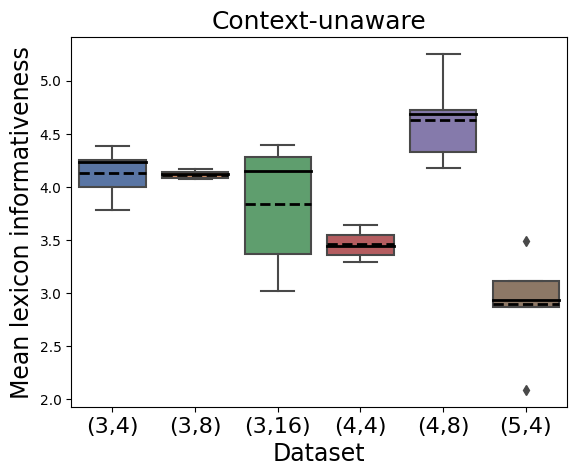

In [32]:
# Create a boxplot for each dataset
sns.boxplot(x='dataset', y='lexicon informativeness', data=df_lexprop, whis=1.5,
            palette='deep', showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
#g.set_titles(col_template="{col_name}", fontsize=50)
#g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
plt.xlabel(xlabel='Dataset', fontsize=17)
plt.ylabel(ylabel='Mean lexicon informativeness', fontsize=17)
plt.xticks(fontsize=16)
#plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=16)
#plt.ylim(0, 21)
if context_unaware:
    plt.title('Context-unaware', fontsize=18)
else:
    plt.title('Context-aware', fontsize=18)
plt.show()

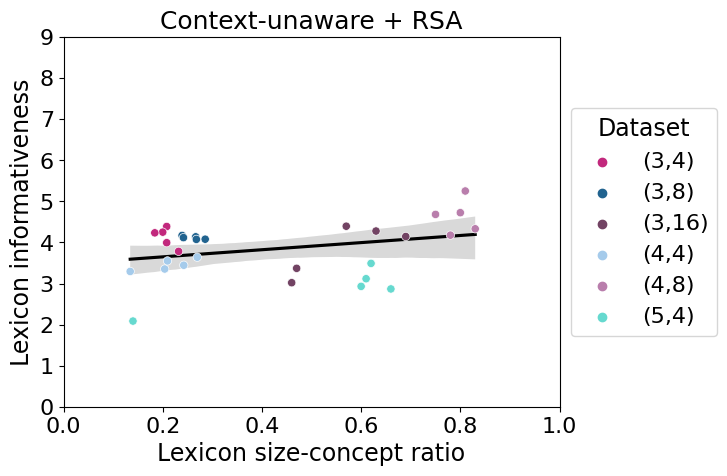

In [33]:
# Create a scatterplot with regression line
scatter = sns.scatterplot(x = 'lexicon ratio', y='lexicon informativeness', data=df_lexprop, hue='dataset', zorder=2, 
                          palette=sns.color_palette(["#c2287d", "#21638f", "#724363", "#a5cbeb", "#b97eac", "#66d9cf"]))
reg = sns.regplot(x = 'lexicon ratio', y = 'lexicon informativeness', data=df_lexprop, scatter=False, color="black")
lines = reg.get_lines()
for line in lines:
    line.set_zorder(1)  # Regression line behind
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='Dataset', title_fontsize=17)
plt.xlabel(xlabel='Lexicon size-concept ratio', fontsize=17)
plt.ylabel(ylabel='Lexicon informativeness', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim(0, 9)
plt.xlim(0, 1)
if context_unaware:
    plt.title('Context-unaware + RSA', fontsize=18)
else:
    plt.title('Context-aware + RSA', fontsize=18)
plt.show()

### Message reuse

In [34]:
# get n_epochs if early stopping
if early_stopping:
    
    n_epochs_all_data = []
    for d in range(len(datasets)):
        
        n_epochs = []
        
        for run in range(n_runs):
    
            path_to_run = paths[d] + '/' + str(setting) +'/' + str(run) + '/' 
            with open(os.path.join(path_to_run, 'loss_and_metrics.pkl'), 'rb') as input_file:
                data = pickle.load(input_file)
                final_epoch = max(data['loss_train'].keys())
                n_epochs.append(final_epoch)
                
        n_epochs_all_data.append(n_epochs)
        
else:
    n_epochs_all_data = []
    for d in range(len(datasets)):
        n_epochs = []
        
        for run in range(n_runs):
            n_epochs.append(epochs)
                
        n_epochs_all_data.append(n_epochs)
            

In [35]:
# go through all datasets
for i, d in enumerate(datasets):
    print(d)
    n_epochs = n_epochs_all_data[i]
    for run in range(5):
        path_to_run = paths[i] + '/' + str(setting) +'/' + str(run) + '/'
        path_to_interaction_train = (path_to_run + 'interactions/train' + '/epoch_' + str(n_epochs[run]) + '/interaction_gpu0')
        path_to_interaction_test = (path_to_run + 'interactions/test/epoch_0/interaction_gpu0')
        path_to_interaction_rsa = (path_to_run + 'interactions/rsa_' + rsa_test + '/epoch_0/interaction_gpu0')
        interaction_train = torch.load(path_to_interaction_train)
        interaction_test = torch.load(path_to_interaction_test)
        interaction_rsa = torch.load(path_to_interaction_rsa)
        
        concepts_train = objects_to_concepts(interaction_train.sender_input, n_values[i])
        concepts_test = objects_to_concepts(interaction_test.sender_input, n_values[i])
        context_test = objects_to_context(interaction_test.sender_input, n_values[i])
                
        accuracies_test = interaction_test.aux['acc']
        accuracies_rsa = interaction_rsa.aux['acc']
        
        # specific and generic concepts test dataset (same as rsa dataset)
        specific_concepts_test, generic_concepts_test, specific_indices, generic_indices, coarse_context_indices, fine_context_indices = [], [], [], [], [], []
        for idx, (objects, fixed) in enumerate(concepts_test):
            if sum(fixed) == n_attributes[i]:
                specific_concepts_test.append((objects, fixed))
                specific_indices.append(idx)
                if context_test[idx] == 0:
                    coarse_context_indices.append(idx)
                if context_test[idx] == (n_attributes[i] - 1):
                    fine_context_indices.append(idx)
            if sum(fixed) == 1:
                generic_concepts_test.append((objects, fixed))
                generic_indices.append(idx)
        
        messages_train = retrieve_messages(interaction_train)
        messages_test = retrieve_messages(interaction_test, is_gumbel=False)
        messages_rsa = retrieve_messages(interaction_rsa, is_gumbel=False)
        
        # remove all symbols after EOS
        messages_train = [remove_symbs_after_eos(message) for message in messages_train]
        messages_test = [remove_symbs_after_eos(message) for message in messages_test]
        messages_rsa = [remove_symbs_after_eos(message) for message in messages_rsa]
        
        # messages used for specific and generic concepts
        specific_messages_test = [messages_test[idx] for idx in specific_indices]
        specific_messages_rsa = [messages_rsa[idx] for idx in specific_indices]
        generic_messages_test = [messages_test[idx] for idx in generic_indices]
        generic_messages_rsa = [messages_rsa[idx] for idx in generic_indices]
        
        # accuracies for specific and generic concepts
        accs_test_specific = [accuracies_test[idx] for idx in specific_indices]
        accs_rsa_specific = [accuracies_rsa[idx] for idx in specific_indices]
        accs_test_specific_fine = [accuracies_test[idx] for idx in fine_context_indices]
        accs_test_specific_coarse = [accuracies_test[idx] for idx in coarse_context_indices]
        accs_rsa_specific_fine = [accuracies_rsa[idx] for idx in fine_context_indices]
        accs_rsa_specific_coarse = [accuracies_rsa[idx] for idx in coarse_context_indices]
        accs_test_generic = [accuracies_test[idx] for idx in generic_indices]
        accs_rsa_generic = [accuracies_rsa[idx] for idx in generic_indices]
    
        symbol_counts_train = count_symbols(messages_train)
        symbol_counts_test = count_symbols(messages_test)
        symbol_counts_rsa = count_symbols(messages_rsa)
        symbol_counts = [symbol_counts_train, symbol_counts_test, symbol_counts_rsa]
        pickle.dump(symbol_counts, open(path_to_run + 'symbol_counts_' + str(rsa_test) + '.pkl', 'wb'))
        
        # consider only unique messages
        messages_train_unique = get_unique_message_set(messages_train)
        messages_test_unique = get_unique_message_set(messages_test)
        specific_messages_test_unique = get_unique_message_set(specific_messages_test)
        generic_messages_test_unique = get_unique_message_set(generic_messages_test)
        messages_rsa_unique = get_unique_message_set(messages_rsa)
        specific_messages_rsa_unique = get_unique_message_set(specific_messages_rsa)
        generic_messages_rsa_unique = get_unique_message_set(generic_messages_rsa)
        messages_comb = [len(messages_train_unique), len(messages_test_unique), len(specific_messages_test_unique), len(generic_messages_test_unique), len(messages_rsa_unique), len(specific_messages_rsa_unique), len(generic_messages_rsa_unique)]
        
        # concepts
        concepts_train_unique = get_unique_concept_set(concepts_train)
        concepts_test_unique = get_unique_concept_set(concepts_test)
        specific_concepts_test_unique = get_unique_concept_set(specific_concepts_test)
        generic_concepts_test_unique = get_unique_concept_set(generic_concepts_test)
        num_of_concepts = [len(concepts_train_unique), len(concepts_test_unique), len(specific_concepts_test_unique), len(generic_concepts_test_unique)]
        pickle.dump(num_of_concepts, open(path_to_run + 'num_of_concepts_' + str(rsa_test) + '.pkl', 'wb'))
        
        # messages used in training reused in testing:
        intersection_test = messages_test_unique & messages_train_unique
        intersection_test_specific = specific_messages_test_unique & messages_train_unique
        intersection_test_generic = generic_messages_test_unique & messages_train_unique
        intersection_rsa = messages_rsa_unique & messages_train_unique
        intersection_rsa_specific = specific_messages_rsa_unique & messages_train_unique
        intersection_rsa_generic = generic_messages_rsa_unique & messages_train_unique
        
        # messages that are used in both normal testing and rsa testing
        intersection_both = messages_test_unique & messages_rsa_unique
        
        # # messages from training not reused in testing:
        # difference_train = messages_train_unique - messages_test_unique
        # 
        # # messages only used in testing:
        difference_test = messages_test_unique - messages_train_unique
        difference_rsa = messages_rsa_unique - messages_train_unique
        print("test:", len(difference_test), "novel messages used for the", len(concepts_test_unique), "novel concepts")
        difference_test_specific = specific_messages_test_unique - messages_train_unique
        difference_test_generic = generic_messages_test_unique - messages_train_unique
        difference_rsa_specific = specific_messages_rsa_unique - messages_train_unique
        difference_rsa_generic = generic_messages_rsa_unique - messages_train_unique
        print("specific test:", len(difference_test_specific), "novel messages used for the", len(specific_concepts_test_unique), "novel concepts")
        print("generic test:", len(difference_test_generic), "novel messages used for the", len(generic_concepts_test_unique), "novel concepts")
        
        message_reuse = [len(messages_train_unique), len(concepts_test_unique), len(messages_test_unique), len(messages_rsa_unique), len(intersection_test), len(intersection_rsa), len(intersection_both), len(difference_test), len(difference_rsa)]
        pickle.dump(message_reuse, open(path_to_run + 'message_reuse_' + str(rsa_test) + '.pkl', 'wb'))
        
        accuracies = [np.mean(accs_test_specific), np.mean(accs_test_specific_fine), np.mean(accs_test_specific_coarse), np.mean(accs_test_generic), np.mean(accs_rsa_specific), np.mean(accs_rsa_specific_fine), np.mean(accs_rsa_specific_coarse), np.mean(accs_rsa_generic)]
        pickle.dump(accuracies, open(path_to_run + 'accuracies_' + str(rsa_test) + '.pkl', 'wb'))

(3,4)
test: 38 novel messages used for the 106 novel concepts
specific test: 9 novel messages used for the 16 novel concepts
generic test: 10 novel messages used for the 20 novel concepts
test: 58 novel messages used for the 106 novel concepts
specific test: 11 novel messages used for the 16 novel concepts
generic test: 11 novel messages used for the 20 novel concepts
test: 49 novel messages used for the 106 novel concepts
specific test: 10 novel messages used for the 16 novel concepts
generic test: 9 novel messages used for the 20 novel concepts
test: 38 novel messages used for the 106 novel concepts
specific test: 5 novel messages used for the 16 novel concepts
generic test: 16 novel messages used for the 20 novel concepts
test: 51 novel messages used for the 106 novel concepts
specific test: 7 novel messages used for the 16 novel concepts
generic test: 8 novel messages used for the 20 novel concepts
(3,8)
test: 490 novel messages used for the 551 novel concepts
specific test: 97 nov

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


test: 5 novel messages used for the 37 novel concepts
specific test: 2 novel messages used for the 7 novel concepts
generic test: 0 novel messages used for the 0 novel concepts
test: 6 novel messages used for the 37 novel concepts
specific test: 0 novel messages used for the 7 novel concepts
generic test: 0 novel messages used for the 0 novel concepts
test: 17 novel messages used for the 37 novel concepts
specific test: 3 novel messages used for the 7 novel concepts
generic test: 0 novel messages used for the 0 novel concepts
test: 0 novel messages used for the 37 novel concepts
specific test: 0 novel messages used for the 7 novel concepts
generic test: 0 novel messages used for the 0 novel concepts
(4,4)
test: 302 novel messages used for the 809 novel concepts
specific test: 27 novel messages used for the 49 novel concepts
generic test: 19 novel messages used for the 50 novel concepts
test: 416 novel messages used for the 809 novel concepts
specific test: 39 novel messages used for th

In [36]:
acc_dict = {'test specific': [], 'test fine': [], 'test coarse': [], 'test generic': [], 
                      'rsa specific': [], 'rsa fine': [], 'rsa coarse': [],
                      'rsa generic': []}
for i, d in enumerate(datasets):
    accs_test_specific, accs_test_specific_fine, accs_test_specific_coarse, accs_test_generic, accs_rsa_specific, accs_rsa_specific_fine, accs_rsa_specific_coarse, accs_rsa_generic = [], [], [], [], [], [], [], []
    for run in range(5):
        path_to_run = paths[i] + '/' + str(setting) +'/' + str(run) + '/'
        acc_means = pickle.load(open(path_to_run + 'accuracies_' + str(rsa_test) + '.pkl', 'rb'))
        for j, acc in enumerate(acc_means):
            if j == 0:
                accs_test_specific.append(acc)
            elif j == 1:
                accs_test_specific_fine.append(acc)
            elif j == 2:
                accs_test_specific_coarse.append(acc)
            elif j == 3:
                accs_test_generic.append(acc)
            elif j == 4:
                accs_rsa_specific.append(acc)
            elif j == 5:
                accs_rsa_specific_fine.append(acc)
            elif j == 6:
                accs_rsa_specific_coarse.append(acc)
            elif j == 7:
                accs_rsa_generic.append(acc)
    acc_dict['test specific'].append(accs_test_specific)
    acc_dict['test fine'].append(accs_test_specific_fine)
    acc_dict['test coarse'].append(accs_test_specific_coarse)
    acc_dict['test generic'].append(accs_test_generic)
    acc_dict['rsa specific'].append(accs_rsa_specific)
    acc_dict['rsa fine'].append(accs_rsa_specific_fine)
    acc_dict['rsa coarse'].append(accs_rsa_specific_coarse)
    acc_dict['rsa generic'].append(accs_rsa_generic)

In [37]:
accuracies = [acc_dict['test specific'], acc_dict['test generic'], acc_dict['rsa specific'], acc_dict['rsa generic']]

# Convert the list to a NumPy array
acc_array = np.array(accuracies)

# Compute means and standard deviations over the five runs
means = np.mean(acc_array, axis=-1)
std_devs = np.std(acc_array, axis=-1)

# Row names and column names
row_names = ["D(3,4)", "D(3,8)", "D(3,16)", "D(4,4)", "D(4,8)", "D(5,4)"]
col_names = ["test specific", "test generic", "rsa specific", "rsa generic"]

# Prepare the data for the DataFrames
data = []

# iterate over datasets
for i in range(means.shape[1]):
    row = []
    # iterate over conditions
    for j in range(means.shape[0]):
        formatted_value = f"{means[j, i]:.2f} $\\pm$ {std_devs[j, i]:.2f}"
        row.append(formatted_value)
    data.append(row)

# Create DataFrames
df = pd.DataFrame(data, index=row_names, columns=col_names)

# Convert DataFrames to LaTeX tables
latex_table = df.to_latex(index=True, escape=False)

print(latex_table)

\begin{tabular}{lllll}
\toprule
{} &    test specific &     test generic &     rsa specific &      rsa generic \\
\midrule
D(3,4)  &  0.79 $\pm$ 0.02 &  0.80 $\pm$ 0.03 &  0.87 $\pm$ 0.04 &  0.88 $\pm$ 0.04 \\
D(3,8)  &  0.87 $\pm$ 0.03 &  0.84 $\pm$ 0.03 &  0.83 $\pm$ 0.03 &  0.79 $\pm$ 0.03 \\
D(3,16) &  0.95 $\pm$ 0.04 &    nan $\pm$ nan &  0.72 $\pm$ 0.03 &    nan $\pm$ nan \\
D(4,4)  &  0.88 $\pm$ 0.02 &  0.88 $\pm$ 0.03 &  0.75 $\pm$ 0.04 &  0.74 $\pm$ 0.04 \\
D(4,8)  &  0.89 $\pm$ 0.07 &    nan $\pm$ nan &  0.66 $\pm$ 0.02 &    nan $\pm$ nan \\
D(5,4)  &  0.88 $\pm$ 0.09 &    nan $\pm$ nan &  0.67 $\pm$ 0.07 &    nan $\pm$ nan \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_44412/3914681832.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=True, escape=False)


In [38]:
accuracies = [acc_dict['test fine'], acc_dict['test coarse'], acc_dict['rsa fine'], acc_dict['rsa coarse']]

# Convert the list to a NumPy array
acc_array = np.array(accuracies)

# Compute means and standard deviations over the five runs
means = np.mean(acc_array, axis=-1)
std_devs = np.std(acc_array, axis=-1)

# Row names and column names
row_names = ["D(3,4)", "D(3,8)", "D(3,16)", "D(4,4)", "D(4,8)", "D(5,4)"]
col_names = ["test fine", "test coarse", "rsa fine", "rsa coarse"]

# Prepare the data for the DataFrames
data = []

# iterate over datasets
for i in range(means.shape[1]):
    row = []
    # iterate over conditions
    for j in range(means.shape[0]):
        formatted_value = f"{means[j, i]:.3f} $\\pm$ {std_devs[j, i]:.2f}"
        row.append(formatted_value)
    data.append(row)

# Create DataFrames
df = pd.DataFrame(data, index=row_names, columns=col_names)

# Convert DataFrames to LaTeX tables
latex_table = df.to_latex(index=True, escape=False)

print(latex_table)

\begin{tabular}{lllll}
\toprule
{} &         test fine &       test coarse &          rsa fine &        rsa coarse \\
\midrule
D(3,4)  &  0.797 $\pm$ 0.02 &  0.795 $\pm$ 0.02 &  0.875 $\pm$ 0.04 &  0.866 $\pm$ 0.04 \\
D(3,8)  &  0.871 $\pm$ 0.03 &  0.871 $\pm$ 0.03 &  0.824 $\pm$ 0.03 &  0.827 $\pm$ 0.04 \\
D(3,16) &  0.948 $\pm$ 0.04 &  0.949 $\pm$ 0.04 &  0.715 $\pm$ 0.03 &  0.718 $\pm$ 0.03 \\
D(4,4)  &  0.879 $\pm$ 0.02 &  0.878 $\pm$ 0.02 &  0.756 $\pm$ 0.03 &  0.746 $\pm$ 0.04 \\
D(4,8)  &  0.887 $\pm$ 0.07 &  0.888 $\pm$ 0.07 &  0.655 $\pm$ 0.02 &  0.656 $\pm$ 0.02 \\
D(5,4)  &  0.880 $\pm$ 0.09 &  0.880 $\pm$ 0.09 &  0.660 $\pm$ 0.07 &  0.669 $\pm$ 0.07 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_44412/3114021474.py:30: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=True, escape=False)


In [54]:
message_reuse_dict = {'# messages train': [], '# messages test': [], '# messages rsa': [], '# concepts test': [], 
                      'reuse rate test': [], 'novelty rate test': [], 'total ratio test': [],
                      'reuse rate rsa': [], 'novelty rate rsa': [], 'total ratio rsa': [],
                      'shared messages test': [], 'shared messages rsa': []}
for i, d in enumerate(datasets):
    train_messages, test_messages, rsa_messages, test_concepts, reuse_test, novelty_test, ratio_test, reuse_rsa, novelty_rsa, ratio_rsa, shared_test, shared_rsa = [], [], [], [], [], [], [], [], [], [], [], []
    for run in range(5):
        path_to_run = paths[i] + '/' + str(setting) +'/' + str(run) + '/'
        message_reuse = pickle.load(open(path_to_run + 'message_reuse_' + str(rsa_test) + '.pkl', 'rb'))
        train_messages.append(message_reuse[0])
        test_messages.append(message_reuse[2])
        rsa_messages.append(message_reuse[3])
        test_concepts.append(message_reuse[1])
        # reuse rate: intersection(train & test) / test
        reuse_test.append(message_reuse[4]/message_reuse[2])
        reuse_rsa.append(message_reuse[5]/message_reuse[3])
        # novelty rate: difference(test - train) / test
        novelty_test.append(message_reuse[7]/message_reuse[2])
        novelty_rsa.append(message_reuse[8]/message_reuse[3])
        # test_messages / test_concepts (novel unique messages & concepts)
        ratio_test.append(message_reuse[2]/message_reuse[1]) 
        ratio_rsa.append(message_reuse[3]/message_reuse[1])
        # shared with rsa: intersection(train & rsa) / test
        shared_test.append(message_reuse[6]/message_reuse[2])
        shared_rsa.append(message_reuse[6]/message_reuse[3])
    message_reuse_dict['# messages train'].append(train_messages)
    message_reuse_dict['# messages test'].append(test_messages)
    message_reuse_dict['# messages rsa'].append(rsa_messages)
    message_reuse_dict['# concepts test'].append(test_concepts)
    message_reuse_dict['reuse rate test'].append(reuse_test)
    message_reuse_dict['novelty rate test'].append(novelty_test)
    message_reuse_dict['total ratio test'].append(ratio_test)
    message_reuse_dict['reuse rate rsa'].append(reuse_rsa)
    message_reuse_dict['novelty rate rsa'].append(novelty_rsa)
    message_reuse_dict['total ratio rsa'].append(ratio_rsa)
    message_reuse_dict['shared messages test'].append(shared_test)
    message_reuse_dict['shared messages rsa'].append(shared_rsa)

In [55]:
message_reuse_test = [message_reuse_dict['# concepts test'], message_reuse_dict['# messages test'], message_reuse_dict['novelty rate test'], message_reuse_dict['shared messages test']]

# Convert the list to a NumPy array
mess_reuse_array = np.array(message_reuse_test)

# Compute means and standard deviations over the five runs
means = np.mean(mess_reuse_array, axis=-1)
std_devs = np.std(mess_reuse_array, axis=-1)

# Row names and column names
row_names = ["D(3,4)", "D(3,8)", "D(3,16)", "D(4,4)", "D(4,8)", "D(5,4)"]
col_names = ["\# concepts", "\# messages", "novelty rate", "shared with rsa"]

# Prepare the data for the DataFrames
data = []

# iterate over datasets
for i in range(means.shape[1]):
    row = []
    # iterate over conditions
    for j in range(means.shape[0]):
        if j > 1:
            formatted_value = f"{means[j, i]:.2f} $\\pm$ {std_devs[j, i]:.2f}"
        elif j == 0:
            formatted_value = f"{int(means[j, i])}"
        else:
            formatted_value = f"{means[j, i]:.1f} $\\pm$ {std_devs[j, i]:.1f}"
        row.append(formatted_value)
    data.append(row)

# Create DataFrames
df = pd.DataFrame(data, index=row_names, columns=col_names)

# Convert DataFrames to LaTeX tables
latex_table = df.to_latex(index=True, escape=False)

print(latex_table)

\begin{tabular}{lllll}
\toprule
{} & \# concepts &       \# messages &     novelty rate &  shared with rsa \\
\midrule
D(3,4)  &         106 &    47.8 $\pm$ 9.5 &  0.34 $\pm$ 0.10 &  0.28 $\pm$ 0.06 \\
D(3,8)  &         551 &  151.4 $\pm$ 30.5 &  0.29 $\pm$ 0.02 &  0.27 $\pm$ 0.05 \\
D(3,16) &          37 &   31.6 $\pm$ 11.6 &  0.06 $\pm$ 0.07 &  0.41 $\pm$ 0.25 \\
D(4,4)  &         809 &  109.8 $\pm$ 37.8 &  0.20 $\pm$ 0.03 &  0.31 $\pm$ 0.06 \\
D(4,8)  &          64 &   42.6 $\pm$ 12.8 &  0.03 $\pm$ 0.03 &  0.29 $\pm$ 0.11 \\
D(5,4)  &          64 &    35.0 $\pm$ 1.3 &  0.06 $\pm$ 0.07 &  0.32 $\pm$ 0.10 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_20059/4257314575.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=True, escape=False)


In [56]:
message_reuse_data = [message_reuse_dict['# concepts test'], message_reuse_dict['# messages train']]

# Convert the list to a NumPy array
mess_reuse_array = np.array(message_reuse_data)

# Compute means and standard deviations over the five runs
means = np.mean(mess_reuse_array, axis=-1)
std_devs = np.std(mess_reuse_array, axis=-1)

# Row names and column names
row_names = ["D(3,4)", "D(3,8)", "D(3,16)", "D(4,4)", "D(4,8)", "D(5,4)"]
col_names = ["\# concepts", "\# messages"]

# Prepare the data for the DataFrames
data = []

# iterate over datasets
for i in range(means.shape[1]):
    row = []
    # iterate over conditions
    for j in range(means.shape[0]):
        if j == 0:
            formatted_value = f"{int(means[j, i])}"
        else:
            formatted_value = f"{means[j, i]:.0f} $\\pm$ {std_devs[j, i]:.0f}"
        row.append(formatted_value)
    data.append(row)

# Create DataFrames
df = pd.DataFrame(data, index=row_names, columns=col_names)

# Convert DataFrames to LaTeX tables
latex_table = df.to_latex(index=True, escape=False)

print(latex_table)

\begin{tabular}{lll}
\toprule
{} & \# concepts &      \# messages \\
\midrule
D(3,4)  &         106 &      95 $\pm$ 33 \\
D(3,8)  &         551 &     280 $\pm$ 72 \\
D(3,16) &          37 &  2256 $\pm$ 1543 \\
D(4,4)  &         809 &     251 $\pm$ 86 \\
D(4,8)  &          64 &  2197 $\pm$ 1432 \\
D(5,4)  &          64 &    870 $\pm$ 233 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_20059/1442344648.py:33: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=True, escape=False)


In [57]:
message_reuse_rsa = [message_reuse_dict['# concepts test'], message_reuse_dict['# messages train'], message_reuse_dict['# messages rsa'], message_reuse_dict['reuse rate rsa'], message_reuse_dict['shared messages rsa']]

# Convert the list to a NumPy array
mess_reuse_array = np.array(message_reuse_rsa)

# Compute means and standard deviations over the five runs
means = np.mean(mess_reuse_array, axis=-1)
std_devs = np.std(mess_reuse_array, axis=-1)

# Row names and column names
row_names = ["D(3,4)", "D(3,8)", "D(3,16)", "D(4,4)", "D(4,8)", "D(5,4)"]
col_names = ["\# concepts", "\# messages train", "\# messages rsa", "reuse rate", "shared with test"]

# Prepare the data for the DataFrames
data = []

# iterate over datasets
for i in range(means.shape[1]):
    row = []
    # iterate over conditions
    for j in range(means.shape[0]):
        if j > 1:
            formatted_value = f"{means[j, i]:.2f} $\\pm$ {std_devs[j, i]:.2f}"
        elif j == 0:
            formatted_value = f"{int(means[j, i])}"
        else:
            formatted_value = f"{means[j, i]:.1f} $\\pm$ {std_devs[j, i]:.1f}"
        row.append(formatted_value)
    data.append(row)

# Create DataFrames
df = pd.DataFrame(data, index=row_names, columns=col_names)

# Convert DataFrames to LaTeX tables
latex_table = df.to_latex(index=True, escape=False)

print(latex_table)

\begin{tabular}{llllll}
\toprule
{} & \# concepts &    \# messages train &    \# messages rsa &       reuse rate & shared with test \\
\midrule
D(3,4)  &         106 &      95.2 $\pm$ 33.2 &   15.80 $\pm$ 2.79 &  1.00 $\pm$ 0.00 &  0.82 $\pm$ 0.13 \\
D(3,8)  &         551 &     279.6 $\pm$ 72.3 &   49.80 $\pm$ 7.22 &  1.00 $\pm$ 0.00 &  0.80 $\pm$ 0.08 \\
D(3,16) &          37 &  2256.2 $\pm$ 1543.2 &  30.00 $\pm$ 10.20 &  1.00 $\pm$ 0.00 &  0.43 $\pm$ 0.26 \\
D(4,4)  &         809 &     251.0 $\pm$ 86.0 &  46.00 $\pm$ 15.30 &  1.00 $\pm$ 0.00 &  0.72 $\pm$ 0.07 \\
D(4,8)  &          64 &  2197.2 $\pm$ 1432.2 &   34.80 $\pm$ 7.19 &  1.00 $\pm$ 0.00 &  0.33 $\pm$ 0.07 \\
D(5,4)  &          64 &    870.0 $\pm$ 232.9 &   29.00 $\pm$ 1.79 &  1.00 $\pm$ 0.00 &  0.38 $\pm$ 0.11 \\
\bottomrule
\end{tabular}


/var/folders/k6/03rlh8jd6nqbws0_xg9jh20w0000gq/T/ipykernel_20059/1603733104.py:35: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  latex_table = df.to_latex(index=True, escape=False)


## Message length

In [58]:
ml_dict = {'dataset': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):
        ml = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length' + '_rsa_' + rsa_test_int + '.pkl', 'rb'))
            
        ml_dict['run'].append(run)
        ml_dict['dataset'].append(dataset)
        try: 
            ml_dict['message length'].append(np.mean(ml.numpy()))
        except: 
            ml_dict['message length'].append(np.NaN)
df_ml = pd.DataFrame(ml_dict)

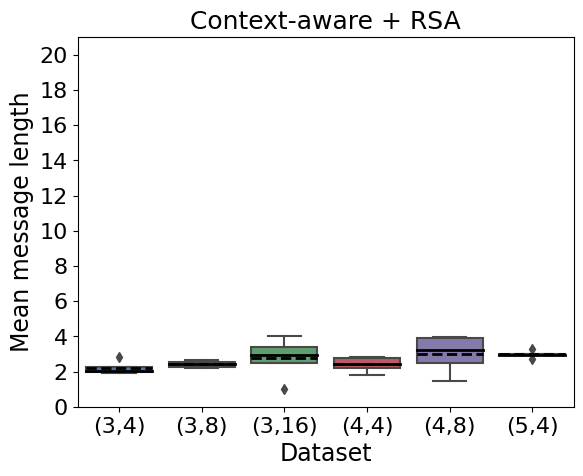

In [59]:
# Create a boxplot for each dataset
sns.boxplot(x='dataset', y='message length', data=df_ml, whis=1.5,
            palette='deep', showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2))
#g.set_titles(col_template="{col_name}", fontsize=50)
#g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
plt.xlabel(xlabel='Dataset', fontsize=17)
plt.ylabel(ylabel='Mean message length', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=16)
plt.ylim(0, 21)
#legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
#plt.setp(legend.get_title(),fontsize='x-large')
if context_unaware:
    plt.title('Context-unaware + RSA', fontsize=18)
else:
    plt.title('Context-aware + RSA', fontsize=18)
plt.show()

### Message lengths per hierarchy level

[2.5, 2.686, 2.894]
[4.0, 4.686, 4.525]
[3.95, 3.529, 3.806]
[2.55, 2.157, 2.162]
[3.9, 3.8, 4.575]
[6.867, 7.164, 7.504]
[6.533, 6.576, 6.698]
[7.367, 7.126, 7.467]
[7.233, 7.54, 7.68]
[8.067, 7.976, 8.239]
[nan, 14.2, 15.171]
[nan, 3.533, 3.0]
[nan, 3.633, 3.843]
[nan, 6.333, 6.429]
[nan, 2.567, 2.486]
[4.42, 4.365, 4.906, 4.876]
[3.68, 4.782, 4.713, 5.145]
[5.98, 6.112, 6.087, 6.724]
[7.0, 6.982, 7.154, 7.141]
[8.04, 7.776, 7.744, 8.214]
[nan, 20.0, 20.0, 20.0]
[nan, 8.7, 8.76, 8.825]
[nan, 4.9, 4.42, 5.025]
[nan, 20.0, 20.0, 20.0]
[nan, 20.0, 20.0, 20.0]
[nan, nan, 11.35, 12.3, 12.075]
[nan, nan, 6.925, 7.4, 8.375]
[nan, nan, 6.225, 7.0, 8.25]
[nan, nan, 12.575, 11.75, 12.725]
[nan, nan, 8.575, 9.55, 9.35]


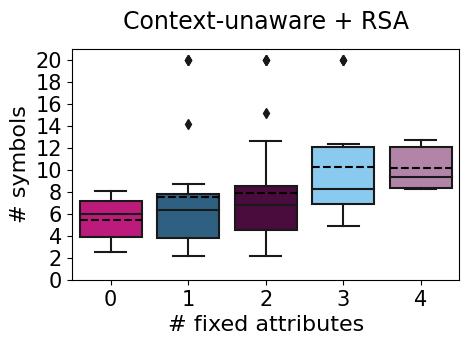

In [10]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(5):

        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_hierarchical' + '_rsa_' + rsa_test_int + '.pkl', 'rb'))

        # if evaluated with the callback throughout training, you get an array for each epoch
        if isinstance(ml_hierarchical, dict): 
            ml_hierarchical = ml_hierarchical['message_length_train'][n_epochs]
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical[level])
            except: 
                ml_dict['message length'].append(np.NaN)
                
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]), showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=1.5))
plt.xticks(fontsize=15)
plt.ylim(1,21)
plt.yticks(fontsize=15, ticks=[0,2,4,6,8,10,12,14,16,18,20])
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
if context_unaware:
    plt.title('Context-unaware + RSA', fontsize=17, y=1.05)
else:
    plt.title('Context-aware + RSA', fontsize=17, y=1.05)
plt.show()

In [61]:
df = pd.DataFrame(ml_dict)
agg = df.groupby('level').agg({'message length': ['mean', 'min', 'max']})
agg

message length              
                mean    min    max
level                             
0           2.575533  1.000  3.500
1           2.533080  0.500  4.500
2           2.619267  1.043  4.143
3           2.844800  1.750  4.125
4           2.955000  2.600  3.550

### Message lengths in fine contexts

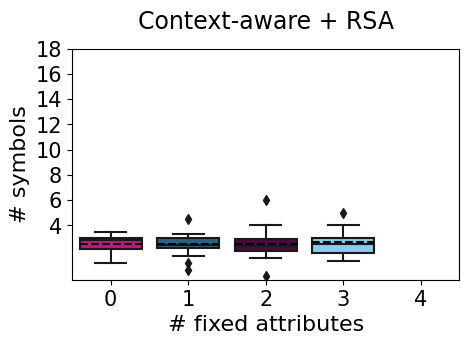

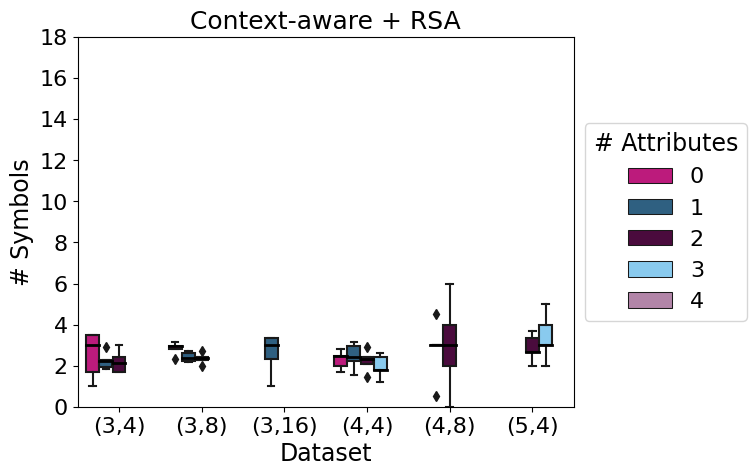

In [62]:
ml_dict = {'level': [], 'data set': [], 'run': [], 'message length': []}
for d, dataset in enumerate(datasets): 
    for run in range(n_runs):

        # if evaluated after training from interaction this is an array showing the message length
        # per level of concreteness (most abstract --> most concrete)
        ml_hierarchical = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + 
                                           '/message_length_over_context_rsa_' + rsa_test_int + '.pkl', 'rb'))
            
        for level in range(5):
            
            ml_dict['level'].append(level)
            ml_dict['run'].append(run)
            ml_dict['data set'].append(dataset)
            try: 
                ml_dict['message length'].append(ml_hierarchical['ml_fine_context'][level])
            except: 
                ml_dict['message length'].append(np.NaN)
                
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='message length', data=ml_dict, palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]), showmeans=True, meanline=True, meanprops=dict(color="black", linestyle="--", linewidth=1.5))
plt.xticks(fontsize=15)
plt.yticks(fontsize=15, ticks=[4,6,8,10,12,14,16,18])
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('# symbols', fontsize=16)
if context_unaware:
    plt.title('Context-unaware + RSA', fontsize=17, y=1.05)
else:
    plt.title('Context-aware + RSA', fontsize=17, y=1.05)
plt.show()
                
# Create a boxplot for each dataset
sns.boxplot(x='data set', y='message length', data=pd.DataFrame(ml_dict), whis=1.5, hue='level', 
            showmeans=False, meanline=False, meanprops=dict(color="black", linestyle="--", linewidth=2), medianprops=dict(color="black", linewidth=2),
            palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]))
#g.set_titles(col_template="{col_name}", fontsize=50)
#g.set_axis_labels('# fixed attributes', '# symbols', fontsize=16)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=16, title='# Attributes', title_fontsize=17)
plt.xlabel(xlabel='Dataset', fontsize=17)
plt.ylabel(ylabel='# Symbols', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks([0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20], fontsize=16)
plt.ylim(0, 18)
#legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
#plt.setp(legend.get_title(),fontsize='x-large')
if context_unaware:
    plt.title('Context-unaware + RSA in fine contexts', fontsize=18)
else:
    plt.title('Context-aware + RSA', fontsize=18)
plt.show()

## Symbol redundancy

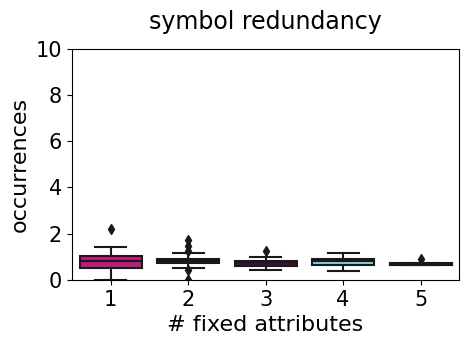

In [5]:
symbol_redundancy_dict = {'level': [], 'data set': [], 'run': [], 'symbol frequency': []}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/symbol_redundancy_rsa_' + rsa_test + '.pkl', 'rb'))
            
        for level in range(5):
            
            symbol_redundancy_dict['level'].append(level)
            symbol_redundancy_dict['run'].append(run)
            symbol_redundancy_dict['data set'].append(dataset)
            try: 
                symbol_redundancy_dict['symbol frequency'].append(scores['symbol_redundancy'][level])
            except: 
                symbol_redundancy_dict['symbol frequency'].append(np.NaN)
plt.figure(figsize=(5,3))
sns.boxplot(x='level', y='symbol frequency', data=symbol_redundancy_dict, palette=sns.color_palette(["#d70082", "#21638f", "#550043", "#78cfff", "#b97eac", "#66d9cf"]))
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5], fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0,10)
plt.xlabel('# fixed attributes', fontsize=16)
plt.ylabel('occurrences', fontsize=16)
plt.title('symbol redundancy', fontsize=17, y=1.05)
plt.show()

## Entropy scores

In [63]:
entropy_scores = load_entropies(paths, context_unaware=context_unaware, length_cost=length_cost, shared_context=shared_context, hierarchical=hierarchical, rsa=True, rsa_test=rsa_test, verbose=True) # 
entropies = [entropy_scores['NMI'], entropy_scores['effectiveness'], entropy_scores['consistency']]

Entropy scores loaded from: results/(3,4)_game_size_10_vsf_0/length_cost/context_aware/shared_context/0/entropy_scores_rsa_testtrainmixed.pkl
Entropy scores loaded from: results/(3,4)_game_size_10_vsf_0/length_cost/context_aware/shared_context/1/entropy_scores_rsa_testtrainmixed.pkl
Entropy scores loaded from: results/(3,4)_game_size_10_vsf_0/length_cost/context_aware/shared_context/2/entropy_scores_rsa_testtrainmixed.pkl
Entropy scores loaded from: results/(3,4)_game_size_10_vsf_0/length_cost/context_aware/shared_context/3/entropy_scores_rsa_testtrainmixed.pkl
Entropy scores loaded from: results/(3,4)_game_size_10_vsf_0/length_cost/context_aware/shared_context/4/entropy_scores_rsa_testtrainmixed.pkl
Entropy scores loaded from: results/(3,8)_game_size_10_vsf_0/length_cost/context_aware/shared_context/0/entropy_scores_rsa_testtrainmixed.pkl
Entropy scores loaded from: results/(3,8)_game_size_10_vsf_0/length_cost/context_aware/shared_context/1/entropy_scores_rsa_testtrainmixed.pkl
Entrop

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/load_results.py:631: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result_dict[key] = np.array(result_dict[key])


### General

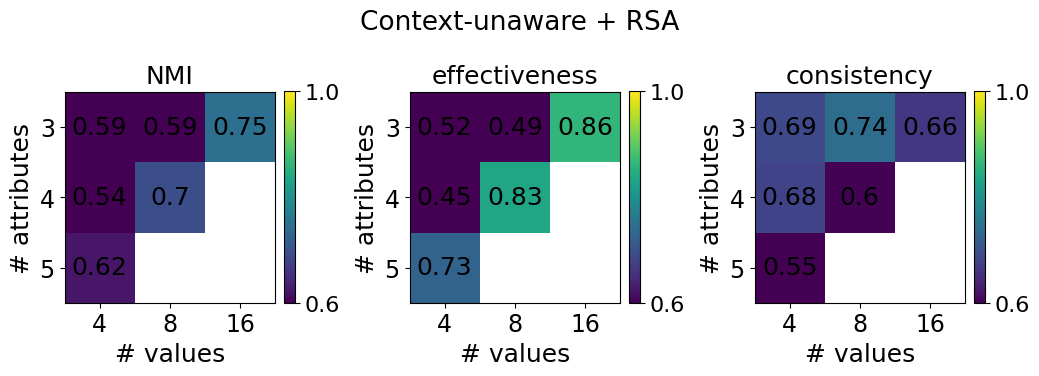

In [64]:
plot_heatmap(entropies, 'mean', plot_dims=(1,3), ylims=(0.6, 1.0), figsize=(10.5, 3.5), 
             titles = ('NMI', 'effectiveness', 'consistency'), suptitle='Context-unaware + RSA')

In [65]:
# means and stds
entropy_dict = {}
for i, score in enumerate(list(entropy_scores.keys())[:3]):
    results = entropies[i]
    mean = np.nanmean(results, axis=-1)
    sd = np.std(results, axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict[d + score] = (round(mean[idx], 3), round(sd[idx], 3))
entropy_dict

{'(3,4)NMI': (0.591, 0.024),
 '(3,8)NMI': (0.594, 0.013),
 '(3,16)NMI': (0.747, 0.037),
 '(4,4)NMI': (0.541, 0.029),
 '(4,8)NMI': (0.697, 0.033),
 '(5,4)NMI': (0.625, 0.031),
 '(3,4)effectiveness': (0.519, 0.033),
 '(3,8)effectiveness': (0.495, 0.016),
 '(3,16)effectiveness': (0.863, 0.094),
 '(4,4)effectiveness': (0.45, 0.037),
 '(4,8)effectiveness': (0.835, 0.093),
 '(5,4)effectiveness': (0.727, 0.051),
 '(3,4)consistency': (0.688, 0.018),
 '(3,8)consistency': (0.743, 0.008),
 '(3,16)consistency': (0.665, 0.038),
 '(4,4)consistency': (0.681, 0.008),
 '(4,8)consistency': (0.602, 0.015),
 '(5,4)consistency': (0.548, 0.019)}

### Concept-dependent

In [66]:
# from generic to specific
entropies_hierarchical = [entropy_scores['NMI_hierarchical'], entropy_scores['effectiveness_hierarchical'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[3:6]):
    results = entropies_hierarchical[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Plotting Concept-level

In [67]:
data_list, run_list, level_list = [], [], []
NMI_hierarchical, effectiveness_hierarchical, consistency_hierarchical = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores_rsa_' + rsa_test_int + '.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_hierarchical.append(scores['normalized_mutual_info_hierarchical'][l])
                effectiveness_hierarchical.append(scores['effectiveness_hierarchical'][l])
                consistency_hierarchical.append(scores['consistency_hierarchical'][l])
            except: 
                NMI_hierarchical.append(np.nan)
                effectiveness_hierarchical.append(np.nan)
                consistency_hierarchical.append(np.nan)

entropy_dict_hierarchical = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_hierarchical, 
                             'Effectiveness': effectiveness_hierarchical, 'Consistency': consistency_hierarchical}


In [68]:
all_hierarchical = {}
len_ds = len(entropy_dict_hierarchical['Effectiveness'])
all_hierarchical['metric'] = ['Effectiveness'] * len_ds + ['Consistency'] * len_ds + ['NMI'] * len_ds 
all_hierarchical['value'] = (entropy_dict_hierarchical['Effectiveness'] + 
                             entropy_dict_hierarchical['Consistency'] +
                             entropy_dict_hierarchical['NMI'])
all_hierarchical['level'] = entropy_dict_hierarchical['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))


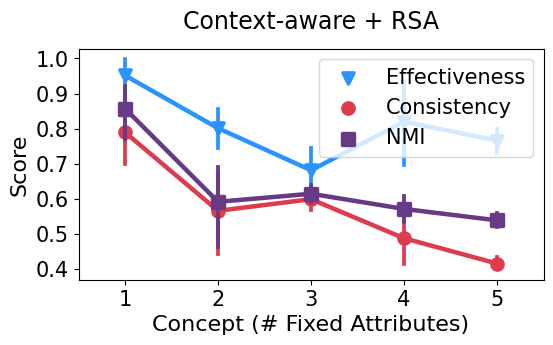

In [69]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_hierarchical, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette(['#2A94FC', '#DC3C4D', '#673A85']), scale=1.2)
plt.ylabel('Score', fontsize=16)
if context_unaware:
    plt.title('Context-unaware + RSA', fontsize=17, y=1.05)
else:
    plt.title('Context-aware + RSA', fontsize=17, y=1.05)
#plt.ylim([0.3,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[1,2,3,4,5], fontsize=15)
plt.yticks(fontsize=15)
plt.xlabel('Concept (# Fixed Attributes)', fontsize=16)
plt.legend(fontsize=15, loc='upper right')
plt.show()

### Context-dependent

In [44]:
# from coarse to fine context
entropies_context_dep = [entropy_scores['NMI_context_dep'], entropy_scores['effectiveness_context_dep'], entropy_scores['consistency_context_dep']]
entropy_dict_context_dep = {}
for i, score in enumerate(list(entropy_scores.keys())[6:9]):
    results = entropies_context_dep[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_context_dep[d + score] = mean[idx] #(mean[idx], sd[idx])


#### Plotting per Context condition

In [45]:
data_list, run_list, level_list = [], [], []
NMI_context_dep, effectiveness_context_dep, consistency_context_dep = [], [], []

for d, data in enumerate(datasets):
    for run in range(5):
        
        scores = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/entropy_scores_rsa_' + rsa_test_int + '.pkl', 'rb'))
        
        for l, level in enumerate([1, 2, 3, 4, 5]):  
            
            data_list.append(data)
            run_list.append(run)
            level_list.append(level)
            
            try: 
                NMI_context_dep.append(scores['normalized_mutual_info_context_dep'][l])
                effectiveness_context_dep.append(scores['effectiveness_context_dep'][l])
                consistency_context_dep.append(scores['consistency_context_dep'][l])
            except: 
                NMI_context_dep.append(np.nan)
                effectiveness_context_dep.append(np.nan)
                consistency_context_dep.append(np.nan)

entropy_dict_context_dep = {'data': data_list, 'level': level_list, 'run': run_list, 'NMI': NMI_context_dep, 
                             'Effectiveness': effectiveness_context_dep, 'Consistency': consistency_context_dep}


In [46]:
all_context_dep = {}
len_ds = len(entropy_dict_context_dep['Effectiveness'])
all_context_dep['metric'] = ['Effectiveness'] * len_ds + ['Consistency'] * len_ds +['NMI'] * len_ds 
all_context_dep['value'] = (entropy_dict_context_dep['Effectiveness'] + 
                             entropy_dict_context_dep['Consistency'] +
                             entropy_dict_context_dep['NMI']
                            )
all_context_dep['level'] = entropy_dict_context_dep['level'] * 3

/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of empty slice
  boot_dist.append(f(*sample, **func_kwargs))
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1559: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a,
/Users/kkobrock/opt/miniconda3/envs/egg/lib/python3.9/site-packages/seaborn/algorithms.py:98: RuntimeWarning: Mean of e

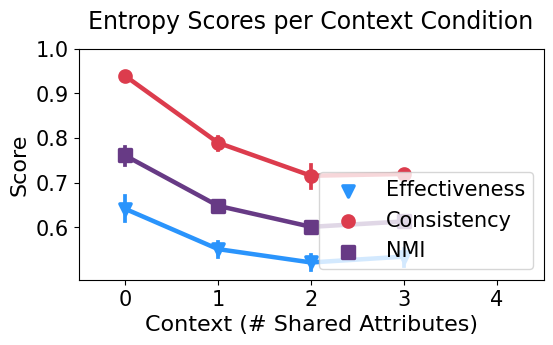

In [48]:
plt.figure(figsize=(6,3))
ax = sns.pointplot(x='level', y='value', data=all_context_dep, hue='metric', errorbar=('ci', 95),
                   markers=['v', 'o', 's'], palette=sns.color_palette(['#2A94FC', '#DC3C4D', '#673A85']), 
                   scale=1.2)
plt.ylabel('Score', fontsize=16)
plt.title('Entropy Scores per Context Condition', fontsize=17, y=1.05)
#plt.ylim([0.6,1.01])
plt.xticks(ticks=[0,1,2,3,4], labels=[0,1,2,3,4])
plt.yticks(ticks=[0.6,0.7, 0.8, 0.9, 1.0], fontsize=15)
plt.xlabel('Context (# Shared Attributes)', fontsize=16)
plt.xticks(fontsize=15)
plt.legend(fontsize=15, loc='lower right')
plt.show()

### Concept x Context

In [272]:
# from generic&coarse to specific&fine
entropies_concept_x_context = [entropy_scores['NMI_concept_x_context'], entropy_scores['effectiveness_concept_x_context'], entropy_scores['consistency_concept_x_context']]
entropy_dict_conc_x_cont = {}
for i, score in enumerate(list(entropy_scores.keys())[9:]):
    results = entropies_concept_x_context[i]
    mean = np.mean(results, axis=-1)
    #sd = results.std(axis=-1)
    for idx, d in enumerate(datasets):
        entropy_dict_conc_x_cont[d + score] = mean[idx] #(mean[idx], sd[idx])

#### NMI

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/plot_helpers.py:141: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


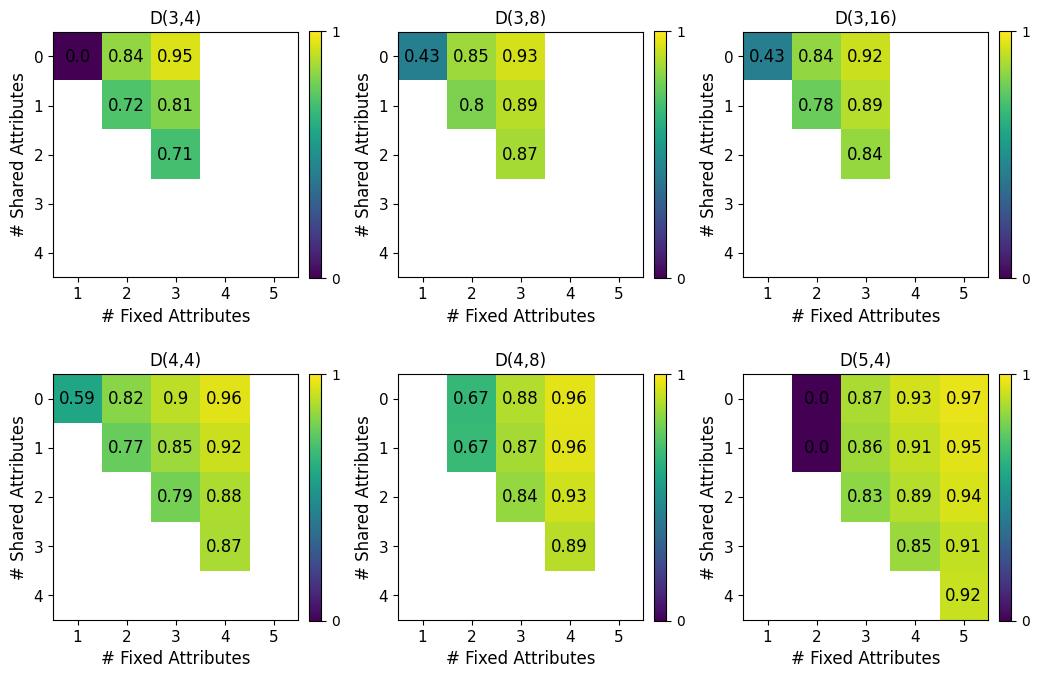

In [273]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='NMI', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims = (0, 1))

#### effectiveness

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/plot_helpers.py:141: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


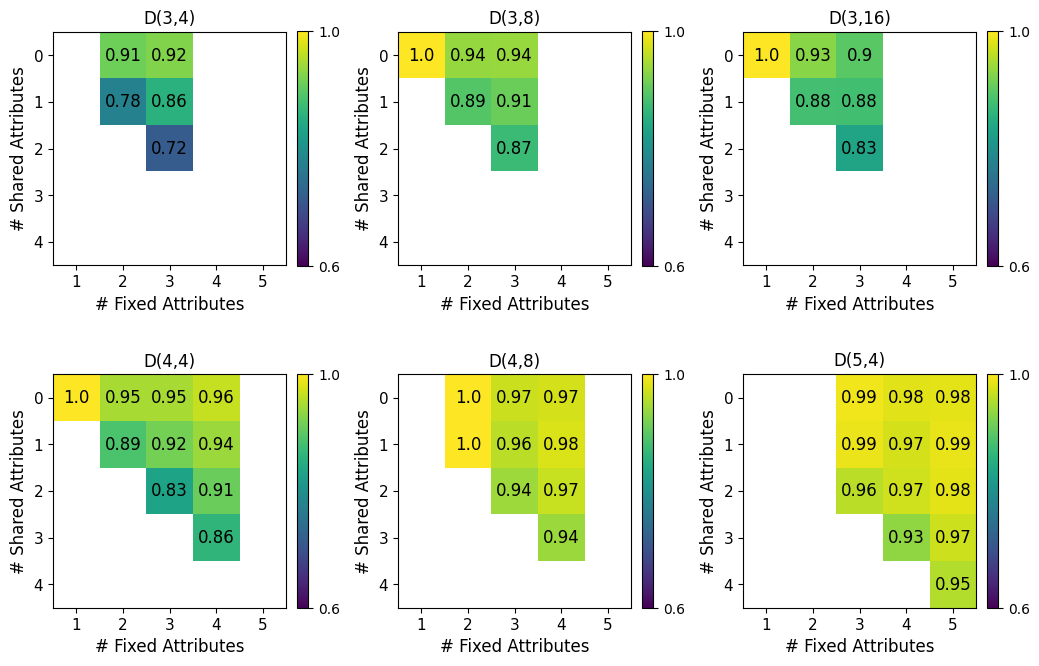

In [274]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='effectiveness', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12)

#### consistency

/Users/kkobrock/Projects/phdproject1/emergent-abstractions/utils/plot_helpers.py:141: RuntimeWarning: Mean of empty slice
  values = np.nanmean(results_ls, axis=0)


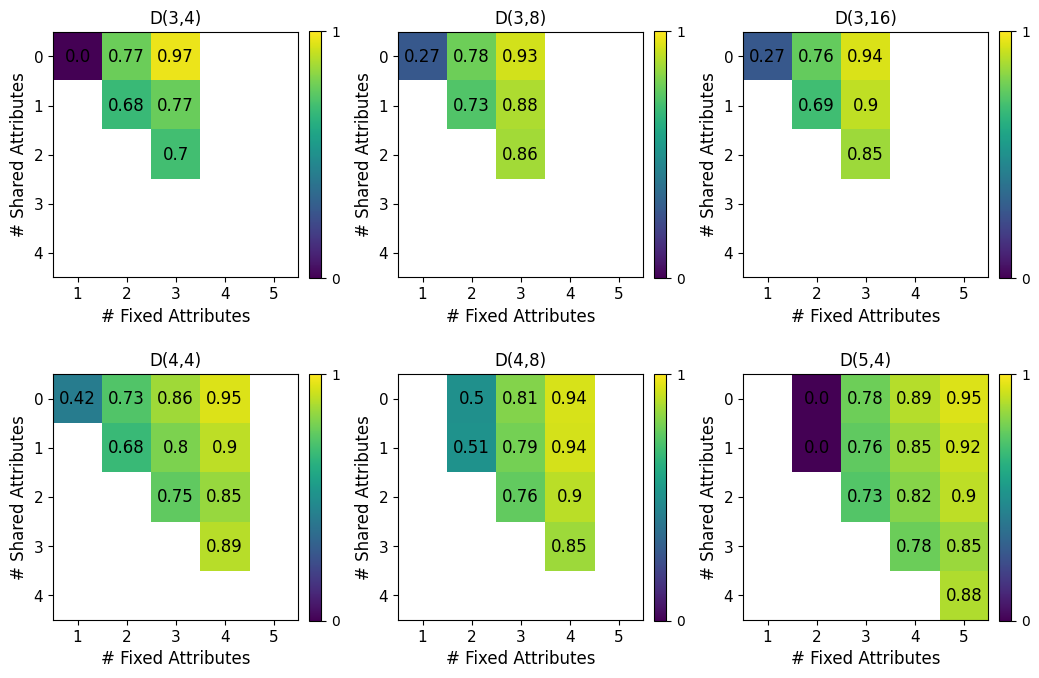

In [275]:
plot_heatmap_concept_x_context(entropies_concept_x_context, score='consistency', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,1))

## Qualitative examples

In [39]:
context_unaware = True # whether original or context_unaware simulations are evaluated
length_cost = True # whether length_cost was applied
early_stopping = True
hierarchical = False
shared_context = True
rsa = False
rsa_test = 'testtrainmixed' # use 'test_load_train' (and 'testtrain' for use with interactions) for RSA setting where RSA tests have been done on training utterances and test datasets, use 'test' for RSA setting where testing was done on test utterances and test dataset
test = 'test'
rsa_test_int = 'testtrainmixed' # use 'testtrain' if rsa_test == 'test_load_train' else use same as rsa_test
if length_cost:
    if context_unaware:
        setting = 'length_cost/context_unaware'
    elif not context_unaware:
        setting = 'length_cost/context_aware'
else:
    if context_unaware:
        setting = 'context_unaware'
    else:
        setting = 'standard'
if hierarchical:
    setting = setting + "/hierarchical"
if shared_context:
    setting = setting + "/shared_context"

In [40]:
# get n_epochs if early stopping
if early_stopping:
    n_epochs_all_data = []
    
    for d in range(len(datasets)):
        n_epochs = []
        
        for run in range(n_runs):
    
            path_to_run = paths[d] + '/' + str(setting) +'/' + str(run) + '/' 
            with open(os.path.join(path_to_run, 'loss_and_metrics.pkl'), 'rb') as input_file:
                data = pickle.load(input_file)
                final_epoch = max(data['loss_train'].keys())
                n_epochs.append(final_epoch)
        
        n_epochs_all_data.append(n_epochs)

In [41]:
d = 'D(4,4)'
i = 3
rsa = True
for run in range(5):
    path_to_run = paths[i] + '/' + str(setting) +'/' + str(run) + '/'
    path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs_all_data[i][run]) + '/interaction_gpu0')
    path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs_all_data[i][run]) + '/interaction_gpu0')
    path_to_interaction_test = (path_to_run + 'interactions/test/epoch_0/interaction_gpu0')
    path_to_interaction_rsa = (path_to_run + 'interactions/rsa_' + rsa_test_int + '/epoch_0/interaction_gpu0')
    save_path = paths[i] + '/' + str(setting) +'/qualitative/'
    interaction_train = torch.load(path_to_interaction_train)
    interaction_val = torch.load(path_to_interaction_val)
    if rsa:
        interaction_test = torch.load(path_to_interaction_rsa)
    else:
        interaction_test = torch.load(path_to_interaction_test)

    # retrieve "lexicon" based on mutual information
    # hard-code for D(3,4) for now
    favorite_symbol, mutual_information = symbol_frequency_fav(interaction_train, n_attributes=3, n_values=4, vocab_size=5, is_gumbel=True)
    print(favorite_symbol, mutual_information)
    
    messages = retrieve_messages(interaction_test, is_gumbel=False)
    # remove all symbols after EOS
    messages = [remove_symbs_after_eos(message) for message in messages]

    sender_input = interaction_test.sender_input
    print(sender_input.shape)
    n_targets = int(sender_input.shape[1]/2)
    # get target objects and fixed vectors to re-construct concepts
    target_objects = sender_input[:, :n_targets]
    target_objects = k_hot_to_attributes(target_objects, n_values[i])
    # concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
    (objects, fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
    concepts = list(zip(objects, fixed))

    # get distractor objects to re-construct context conditions
    distractor_objects = sender_input[:, n_targets:]
    distractor_objects = k_hot_to_attributes(distractor_objects, n_values[i])
    context_conds = retrieve_context_condition(objects, fixed, distractor_objects)

    # get random qualitative samples
    #fixed_index = random.randint(0, n_attributes[i]-1) # define a fixed index for the concept
    #n_fixed = random.randint(1, n_attributes[i]) # how many fixed attributes?
    #n_fixed = 1
    n_fixed = 4
    fixed_indices = random.sample(range(0, n_attributes[i]), k=n_fixed) # select which attributes are fixed
    #fixed_indices = [2]
    fixed_indices = [0, 1, 2, 3]
    #fixed_value = random.randint(0, n_values[i]-1) # define a fixed value for this index
    fixed_values = random.choices(range(0, n_values[i]), k=n_fixed)
    #fixed_values = [1, 2, 1]
    #fixed_values = [2, 0, 3]
    #fixed_values = [1, 1, 1, 0]
    fixed_values = [2, 2, 3, 3]
    print(n_fixed, fixed_indices, fixed_values)
    #index_threshold = 20000 # optional: define some index threshold to make sure that examples are not taken from the beginning of training
    # TODO: adapt this loop such that multiple indices can be fixed
    all_for_this_concept = []
    for idx, (t_objects, t_fixed) in enumerate(concepts):
        #if sum(t_fixed) == 1 and t_fixed[fixed_index] == 1:# and idx > index_threshold:
        if sum(t_fixed) == n_fixed and all(t_fixed[fixed_index] == 1 for fixed_index in fixed_indices):
            for t_object in t_objects:
                if all(t_object[fixed_index] == fixed_values[j] for j, fixed_index in enumerate(fixed_indices)):
                    all_for_this_concept.append((idx, t_object, t_fixed, context_conds[idx], distractor_objects[idx][0], messages[idx], interaction_test.aux['acc'][idx].item()))
                    fixed = t_fixed
    if len(all_for_this_concept) > 0:
        #sample = random.sample(all_for_this_concept, 20)
        sample = all_for_this_concept
        #print(sample)
        column_names = ['game_nr', 'target', 'fixed indices', 'context condition', 'distractor', 'message', 'accuracy']
        df = pd.DataFrame(sample, columns=column_names)
        df = df.groupby('game_nr').first().reset_index()
        print(df)
        if not os.path.exists(save_path + 'rsa'):
            os.makedirs(save_path + 'rsa')
        df.to_csv(save_path + 'rsa/sample' + str(run) + '_' + str(sample[0][1]) + ',' + str(fixed) + '.csv', index=False)
        print('saved ' + save_path + 'rsa/sample' + str(run) + '_' + str(sample[0][1]) + ',' + str(fixed) + '.csv')
        # find out for which concepts these messages have been used during training
        messages_train = retrieve_messages(interaction_train, is_gumbel=True)
        # remove all symbols after EOS
        messages_train = [remove_symbs_after_eos(message) for message in messages_train]
        sender_input_train = interaction_train.sender_input
        n_targets = int(sender_input_train.shape[1]/2)
        message_usage_train = []
        for j, message in enumerate(messages_train):
            if tuple(message) in get_unique_message_set(df['message']):
                # get target objects and fixed vectors to re-construct concepts
                target_objects = sender_input_train[j, :n_targets].unsqueeze(0)
                target_objects = k_hot_to_attributes(target_objects, n_values[i])
                # concepts are defined by a list of target objects (here one sampled target object) and a fixed vector
                (objects, t_fixed) = retrieve_concepts_sampling(target_objects, all_targets=True)
                concepts = list(zip(objects, t_fixed))
            
                # get distractor objects to re-construct context conditions
                distractor_objects = sender_input_train[j, n_targets:].unsqueeze(0)
                distractor_objects = k_hot_to_attributes(distractor_objects, n_values[i])
                context_conds = retrieve_context_condition(objects, t_fixed, distractor_objects)
                message_usage_train.append((j, message, objects[0][0], t_fixed[0], context_conds[0], distractor_objects[0][0], interaction_train.aux['acc'][j].item()))
        if len(message_usage_train) > 0:
            column_names = ['game_nr', 'message', 'targets', 'fixed indices', 'context condition', 'distractors', 'accuracy']
            df_train = pd.DataFrame(message_usage_train, columns=column_names).sort_values('message')
            print(df_train)
            df_train.to_csv(save_path + 'rsa/mess_usage_train_' + str(run) + '_' + str(sample[0][1]) + ',' + str(fixed) + '.csv', index=False)
            print('saved ' + save_path + 'rsa/mess_usage_train_' + str(run) + '_' + str(sample[0][1]) + ',' + str(fixed) + '.csv')
        else:
            raise ValueError("Message could not be found in train interactions.")
            
    else:
        raise ValueError("sample for dataset " + str(d) + " could not be generated")

{'00': 1, '01': 3, '02': 1, '03': 1, '10': 1, '11': 3, '12': 1, '13': 1, '20': 1, '21': 3, '22': 4, '23': 2} {'00': 0.015023352887862388, '01': 0.009581122552528016, '02': 0.011443957701229628, '03': 0.011380160141515184, '10': 0.006174168399045011, '11': 0.01088813833182475, '12': 0.009948909593986026, '13': 0.004477218761781471, '20': 0.0007502533283742631, '21': 0.00024818066560068766, '22': 0.0005872064221003466, '23': 0.001098069571810385}
torch.Size([1250, 20, 16])
4 [0, 1, 2, 3] [2, 2, 3, 3]
   game_nr                target         fixed indices  context condition  \
0      920  [2.0, 2.0, 3.0, 3.0]  [1.0, 1.0, 1.0, 1.0]                  0   
1      921  [2.0, 2.0, 3.0, 3.0]  [1.0, 1.0, 1.0, 1.0]                  3   
2      922  [2.0, 2.0, 3.0, 3.0]  [1.0, 1.0, 1.0, 1.0]                  2   
3      923  [2.0, 2.0, 3.0, 3.0]  [1.0, 1.0, 1.0, 1.0]                  1   
4      924  [2.0, 2.0, 3.0, 3.0]  [1.0, 1.0, 1.0, 1.0]                  0   
5      925  [2.0, 2.0, 3.0, 3.0]  

## Frequency rank

In [5]:
# comparison with English and Arabic
get_corpus_data(filename='eng_news_2024_10K-words', old_path='../Leipzig corpora collection/eng_news_2024_10K/', new_path='analysis/', idx=31)
get_corpus_data(filename='ara_news_2022_10K-words', old_path='../Leipzig corpora collection/ara_news_2022_10K/', new_path='analysis/', idx=28, arabic=True)
df_english = pd.read_csv('analysis/eng_news_2024_10K-words.csv')
df_arabic = pd.read_csv('analysis/ara_news_2022_10K-words.csv')

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:575: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language['relative frequency'] = language['frequency'] / sum(language['frequency'])
/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/plot_helpers.py:575: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  language['relative frequency'] = language['frequency'] / sum(language['frequency'])


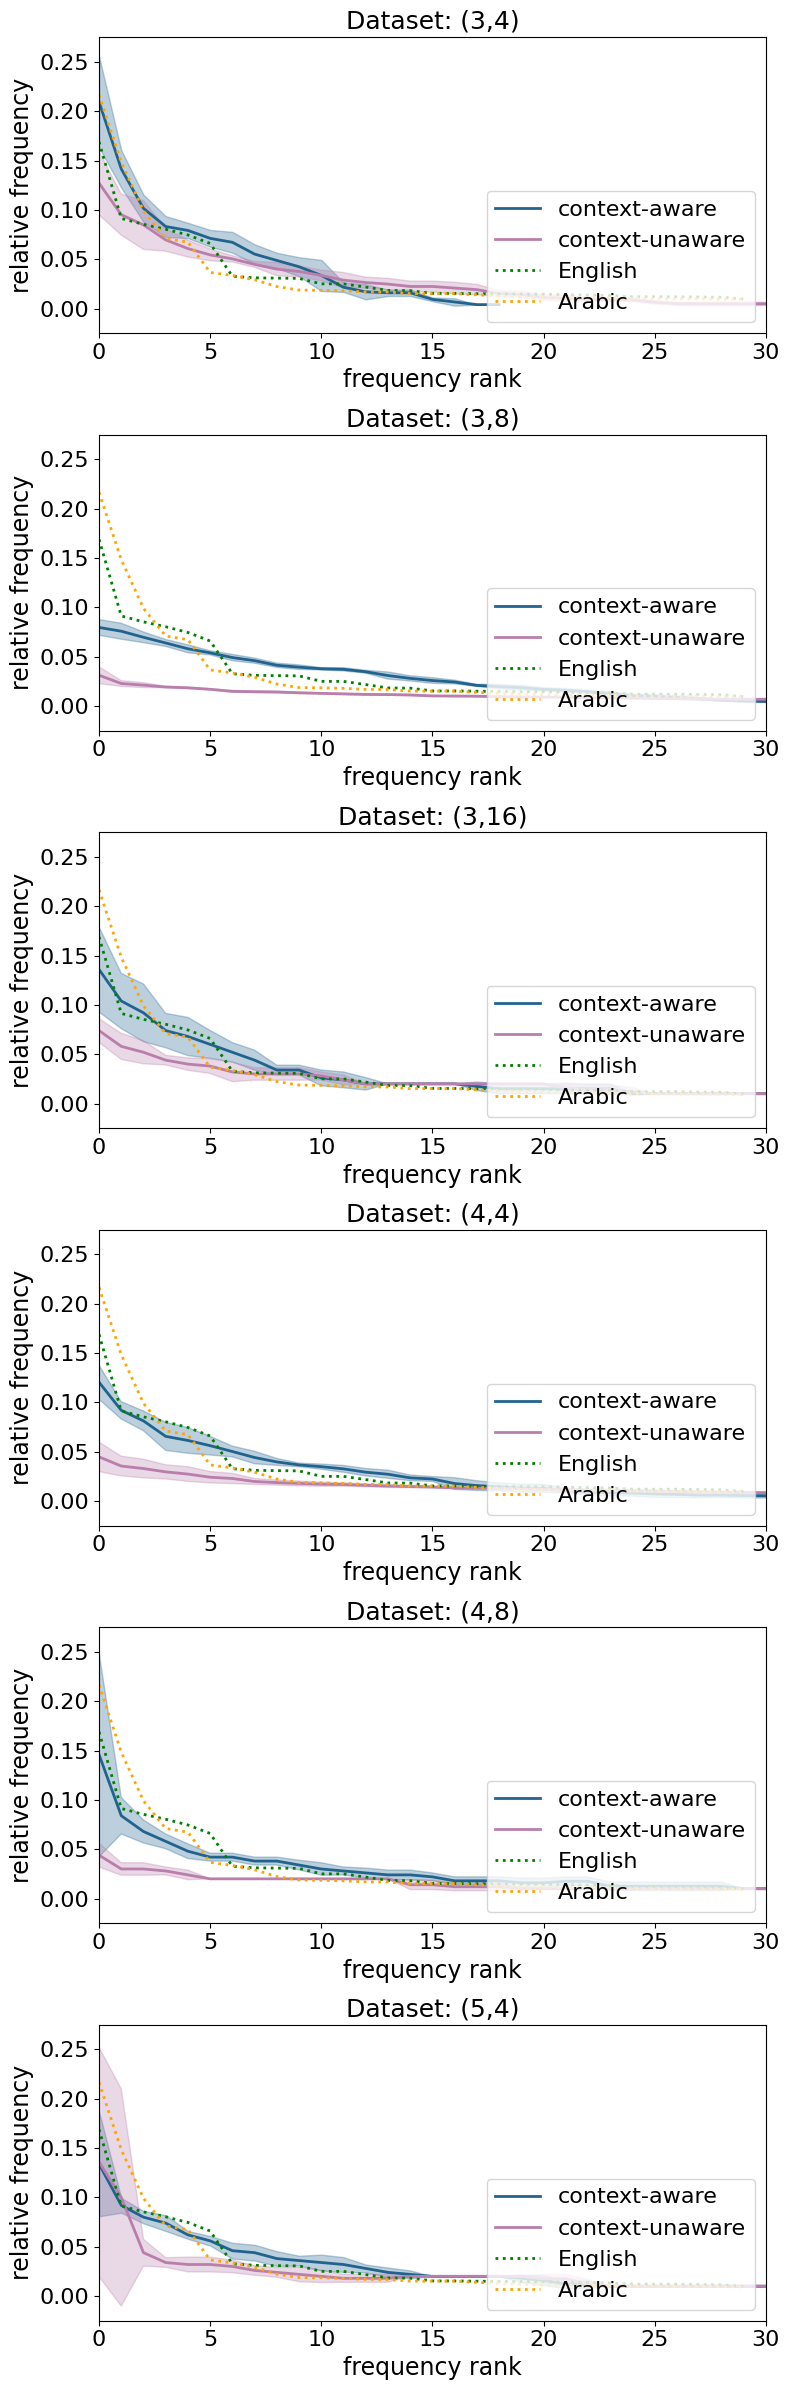

In [6]:
plot_frequency(paths, ["length_cost/context_aware/shared_context", "length_cost/context_unaware/shared_context"], n_runs, n_values, datasets, n_epochs=0, int='rsa', std=True, labels=['context-aware', 'context-unaware', 'English', 'Arabic'], frequency='message', fontsize=16, color=["#21638f", "#b97eac",'green','orange'], ylim=(-0.025, 0.275), yticks=[0, 0.05, 0.1, 0.15, 0.2, 0.25], xlim=(0,30), natural_language=[df_english.iloc[:30], df_arabic.iloc[:30]], linewidth=2)

/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/prep_corpus_data.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"] = df["word"].apply(lambda x: len(x) if type(x) == str and x.isalpha() and x.isascii() else 0)
/Users/kkobrock/Projects/phdproject1/pragmatic-mechanisms/utils/prep_corpus_data.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length"] = df["word"].apply(lambda x: len(araby.strip_diacritics(x)) if x.isalpha() and x.isascii() == False else 0)


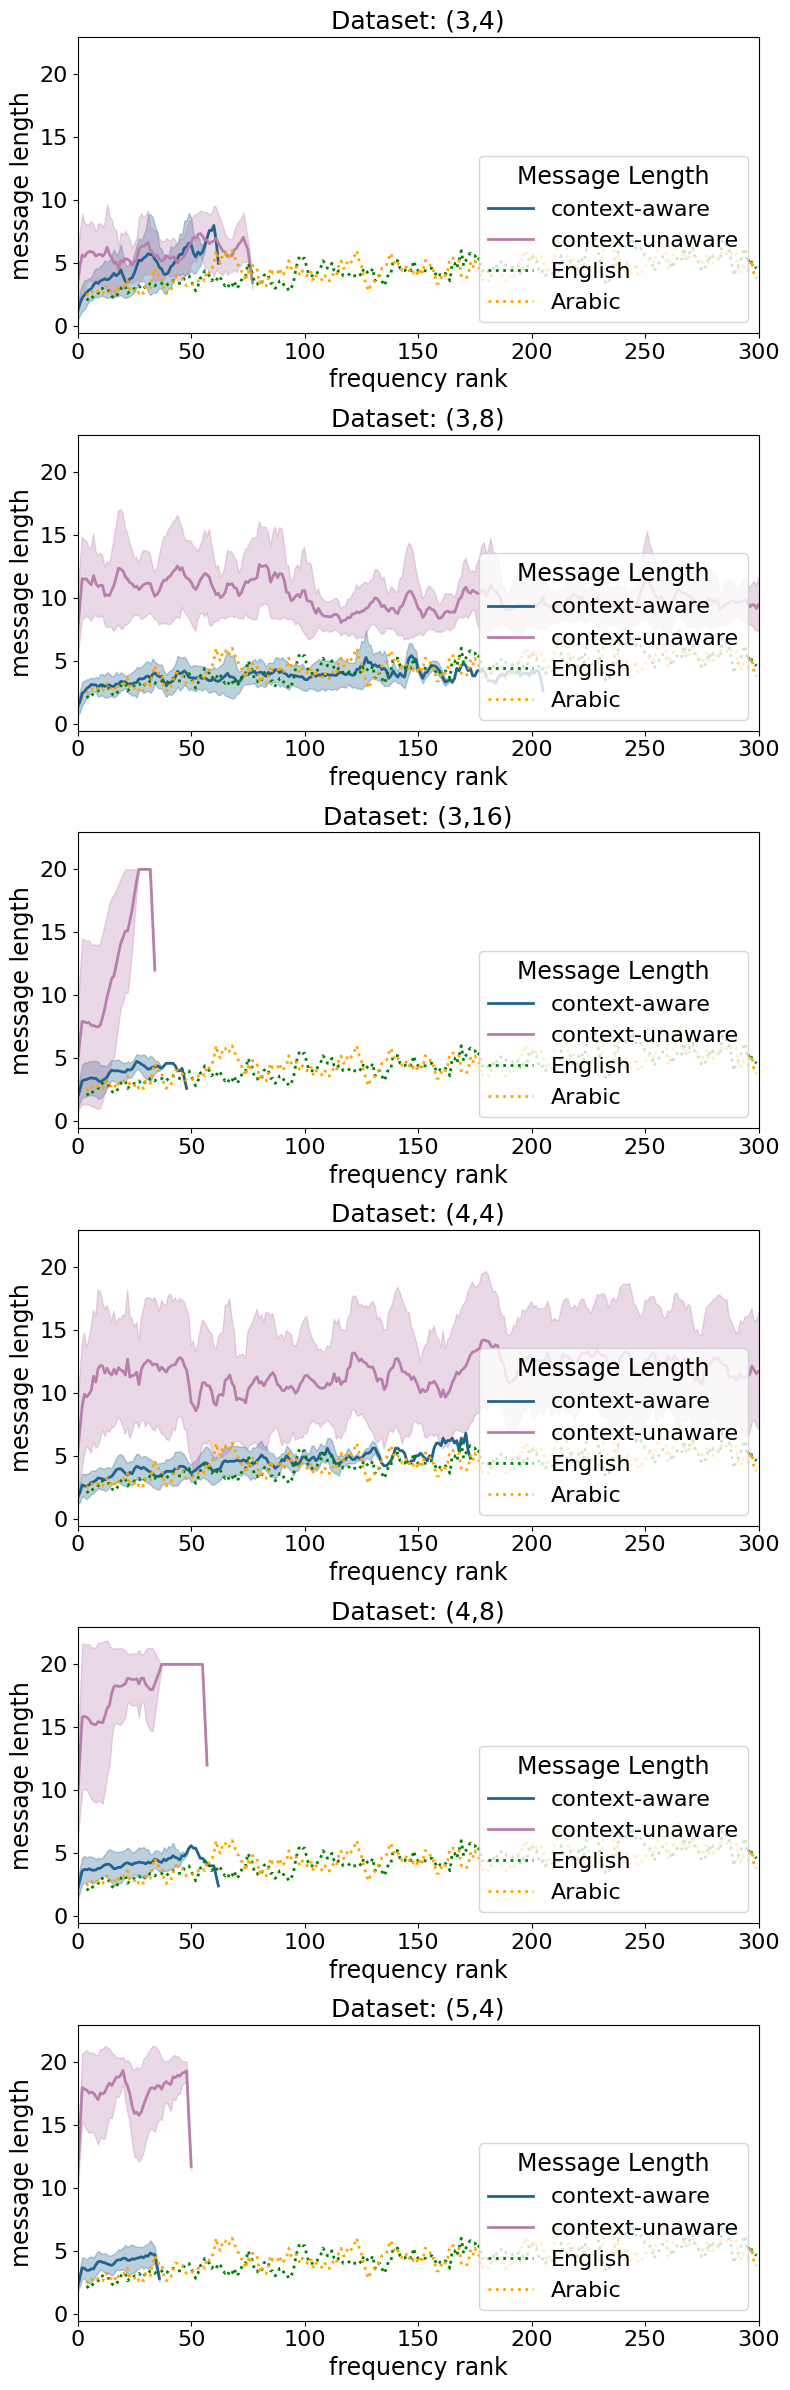

In [7]:
plot_frequency_x_message_length(paths, ["length_cost/context_aware/shared_context", "length_cost/context_unaware/shared_context"], n_runs, n_values, datasets, n_epochs=0, std=True, int='test', labels=['context-aware', 'context-unaware', 'English', 'Arabic'], fontsize=16, color=["#21638f", "#b97eac",'green','orange'], xlim=(0,300), natural_language=[df_english.iloc[:300], df_arabic.iloc[:300]], linewidth=2, window=5)

## Compositionality

In [20]:
topsim, posdis, bosdis = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_specific, posdis_specific, bosdis_specific = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))
topsim_generic, posdis_generic, bosdis_generic = np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5)), np.zeros((n_datasets, 5))

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        #disent_score = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        topsim[d, run] = topsim_score['topsim_train']
        #posdis[d, run] = disent_score['posdis']
        #bosdis[d, run] = disent_score['bosdis']
        topsim_specific[d, run] = topsim_score['topsim_specific_train']
        #posdis_specific[d, run] = disent_score['posdis_specific']
        #bosdis_specific[d, run] = disent_score['bosdis_specific']
        topsim_generic[d, run] = topsim_score['topsim_generic_train']
        #posdis_generic[d, run] = disent_score['posdis_generic']
        #bosdis_generic[d, run] = disent_score['bosdis_generic']

### Topsim

In [21]:
for i, d in enumerate(datasets):
    print(d, "topsim:", round(np.mean(topsim[i]), 3), "sd", round(np.std(topsim[i]), 2))

(3,4) topsim: 0.269 sd 0.04
(3,8) topsim: 0.181 sd 0.02
(3,16) topsim: 0.098 sd 0.02
(4,4) topsim: 0.329 sd 0.04
(4,8) topsim: 0.204 sd 0.06
(5,4) topsim: 0.255 sd 0.03


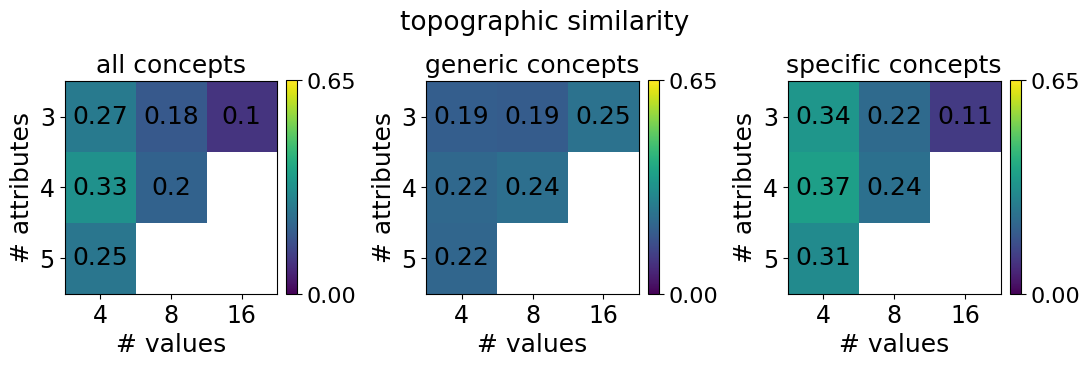

In [22]:
plot_heatmap([topsim, topsim_generic, topsim_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5), 
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='topographic similarity', suptitle_position=1.)

#### Topographic similarity over time

In [12]:
topsim_over_time = {}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        scores = pickle.load(open(paths[d]  + '/' + setting + '/' + str(run) + '/topsim_over_time.pkl', 'rb'))
            
        topsim_over_time[d][run] = scores
            
plt.plot(topsim_over_time[0][0])
round(max(topsim_over_time[0][0]) - min(topsim_over_time[0][0]), 3)

FileNotFoundError: [Errno 2] No such file or directory: 'results/(3,4)_game_size_10_vsf_3/standard/0/topsim_over_time.pkl'

### Posdis

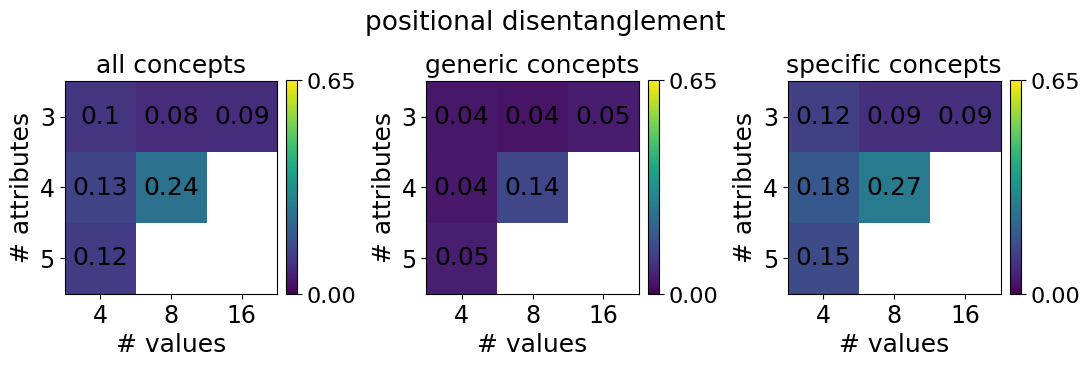

In [44]:
plot_heatmap([posdis, posdis_generic, posdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='positional disentanglement', suptitle_position=1.)

In [52]:
posdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(5):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_scores.pkl', 'rb')))
    posdis.append(sublist)

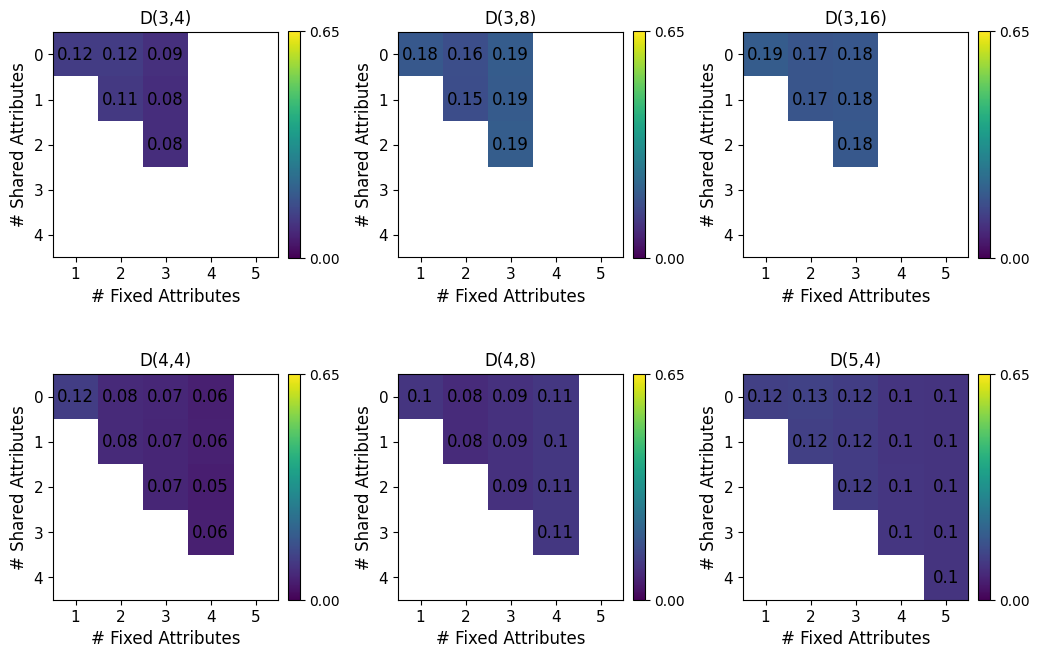

In [53]:
plot_heatmap_concept_x_context(posdis, score='posdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Bosdis

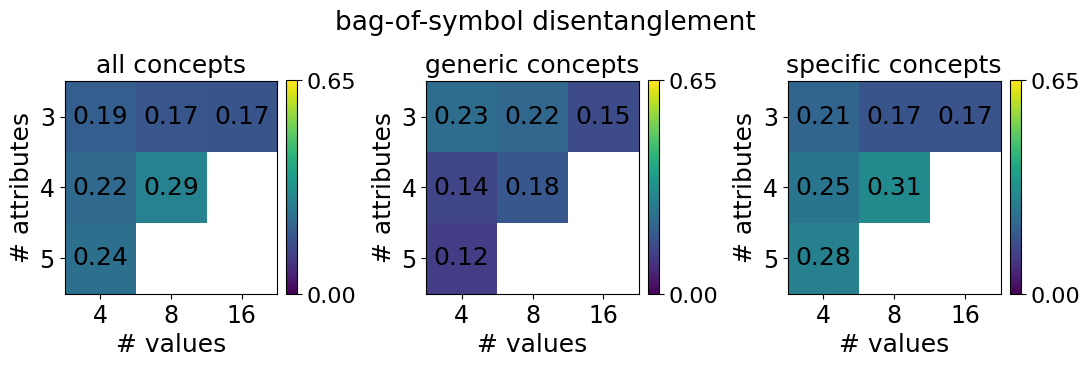

In [48]:
plot_heatmap([bosdis, bosdis_generic, bosdis_specific], 'mean', plot_dims=(1,3), ylims=[0.0,0.65], figsize=(11,3.5),
             titles=['all concepts', 'generic concepts', 'specific concepts'], suptitle='bag-of-symbol disentanglement', suptitle_position=1.)

In [49]:
bosdis = []

for d, dataset in enumerate(datasets): 
    sublist = []
    for run in range(5):
        sublist.append(pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/bosdis_scores.pkl', 'rb')))
    bosdis.append(sublist)

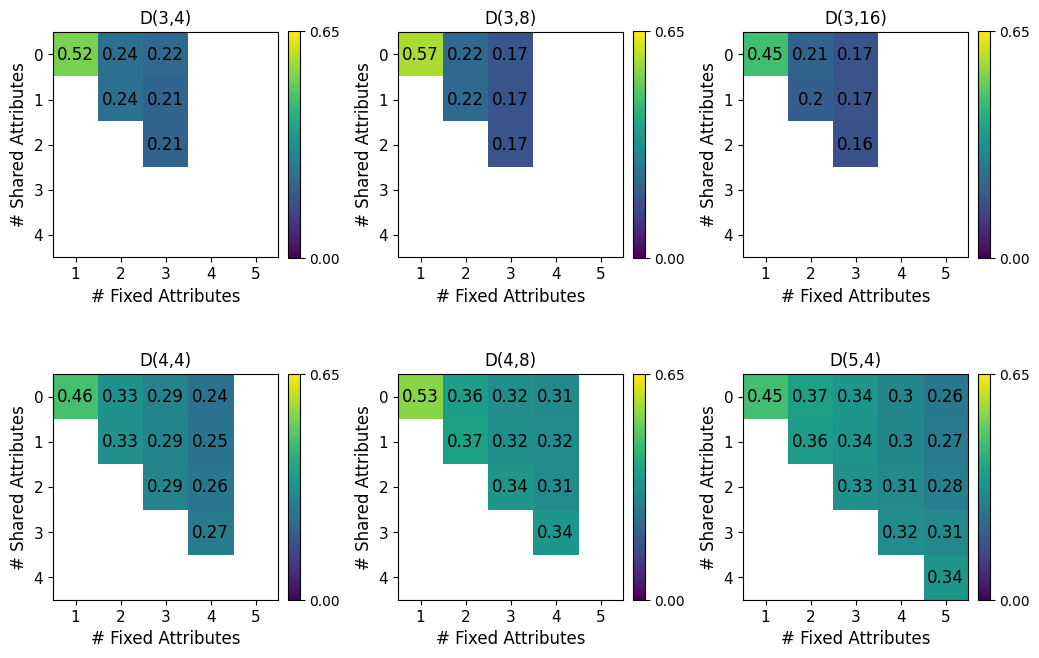

In [50]:
plot_heatmap_concept_x_context(bosdis, score='bosdis', mode='mean', plot_dims=(2,3), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 12, ylims=(0,0.65))

### Compositionality per dataset

In [35]:
# compositionality scores for each data set

compositionality_scores = {'dataset':[], 'run':[], 'metric':[], 'data':[], 'score':[]}

for d, dataset in enumerate(datasets): 
    for run in range(5):
        
        topsim = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/topsim_final.pkl', 'rb'))
        disent = pickle.load(open(paths[d] + '/' + setting + '/' + str(run) + '/posdis_bosdis.pkl', 'rb'))
        
        for metric in ['topsim', 'posdis', 'bosdis']:
            #for data in ['all', 'concrete']: 
            for data in ['all']:
                
                compositionality_scores['dataset'].append(dataset)
                compositionality_scores['run'].append(run)
                compositionality_scores['metric'].append(metric)
                compositionality_scores['data'].append(data)
                
                append = '' if data == 'all' else '_max_relevance'
                    
                if metric == 'topsim':
                    compositionality_scores['score'].append(topsim['topsim' + append + '_train'])
                if metric == 'posdis':
                    compositionality_scores['score'].append(disent['posdis' + append])
                if metric == 'bosdis':
                    compositionality_scores['score'].append(disent['bosdis' + append])

compositionality_scores = pd.DataFrame(compositionality_scores)

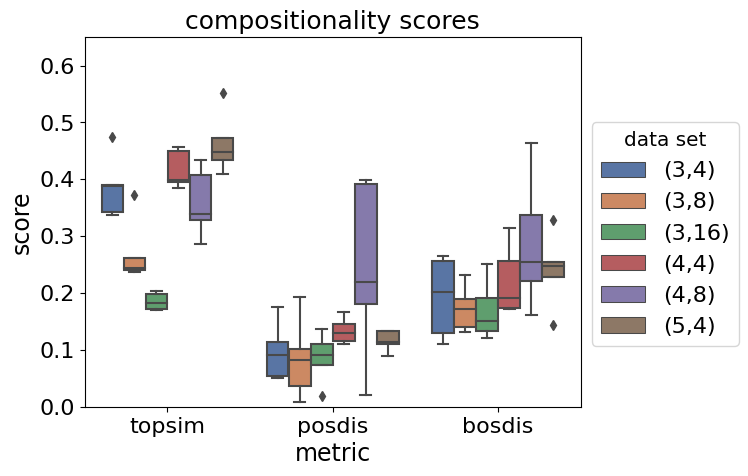

In [40]:
sns.boxplot(x='metric', y='score', data=compositionality_scores[compositionality_scores.data=='all'], 
            hue='dataset', palette='deep')
plt.xlabel(xlabel='metric', fontsize=17)
plt.ylabel(ylabel='score', fontsize=17)
plt.xticks(fontsize=16)
plt.yticks(ticks=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6], fontsize=16)
plt.ylim(0, 0.65)
legend = plt.legend(fontsize=16, title='data set', bbox_to_anchor=(1., 0.8))
plt.setp(legend.get_title(),fontsize='x-large')
plt.title('compositionality scores', fontsize=18)
plt.show()

## Errors

In [200]:
validation = True # set to false if training interaction should be used
setting = 'standard'

In [57]:
import torch
from utils.analysis_from_interaction import *

In [201]:
def error_analysis(datasets, paths, setting, n_epochs, n_values, validation=True):
    """
    goes through interactions, retrieves concept and context conditions and counts errors, 
    i.e. incorrectly classified objects (by the receiver)
    """
    all_error_concepts = {}
    all_error_contexts = {}
    all_error_concept_x_context = {}
    all_false_positives = {}
    all_false_negatives = {}
    all_total_errs = {}

    all_acc_concept_x_context = {}

    all_total_concepts = {}
    all_total_contexts = {}
    all_total_concept_x_context = {}

    # go through all datasets
    for i, d in enumerate(datasets):
        print(i, d)
        error_concepts = {}
        error_contexts = {}
        error_concept_x_context = {}
        false_positives = {}
        false_negatives = {}
        total_errs = {}
        acc_concept_x_context = {}
        # select first run
        path_to_run = paths[i] + '/' + str(setting) + '/' + str(0) + '/'
        path_to_interaction_train = (path_to_run + 'interactions/train/epoch_' + str(n_epochs) + '/interaction_gpu0')
        path_to_interaction_val = (path_to_run + 'interactions/validation/epoch_' + str(n_epochs) + '/interaction_gpu0')
        if validation:
            interaction = torch.load(path_to_interaction_val)
        else:
            interaction = torch.load(path_to_interaction_train)

        total_concepts = obtain_concept_counts(interaction.sender_input, n_values[i])

        total_contexts = obtain_context_counts(interaction.sender_input, n_values[i])

        total_concept_x_context = obtain_concept_x_context_counts(interaction.sender_input, n_values[i])

        for j in range(len(interaction.sender_input)):
            receiver_pred = (interaction.receiver_output[j][-1] > 0).float()  # use last symbol of message

            (objects, fixed) = get_fixed_vectors(interaction.sender_input, n_values[i], j)
            concept_str = str(int(sum(fixed[0])))

            context_conds = get_context_cond(interaction.sender_input, n_values[i], j, objects, fixed)
            context_str = str(context_conds[0])
            concept_x_context_str = (context_conds[0], int(sum(fixed[0]) - 1))
            
            # check if receiver has classified all objects correctly as targets or distractors
            if not torch.equal(receiver_pred, interaction.labels[j]):
                if concept_str in error_concepts:
                    error_concepts[concept_str] += 1
                else:
                    error_concepts[concept_str] = 1

                if context_str in error_contexts:
                    error_contexts[context_str] += 1
                else:
                    error_contexts[context_str] = 1

                if concept_x_context_str in error_concept_x_context:
                    error_concept_x_context[concept_x_context_str] += 1
                else:
                    error_concept_x_context[concept_x_context_str] = 1
                    
                # calculate false positives and false negatives
                num_false_pos = 0
                num_false_neg = 0
                errors = receiver_pred - interaction.labels[j]
                for error in errors:
                    # false positives
                    if error > 0:
                        num_false_pos += 1
                    # false negatives
                    elif error < 0:
                        num_false_neg += 1
                if concept_x_context_str in false_positives:
                    false_positives[concept_x_context_str] += num_false_pos
                else:
                    false_positives[concept_x_context_str] = num_false_pos
                if concept_x_context_str in false_negatives:
                    false_negatives[concept_x_context_str] += num_false_neg
                else:
                    false_negatives[concept_x_context_str] = num_false_neg
                if concept_x_context_str in total_errs:
                    total_errs[concept_x_context_str] += (num_false_pos + num_false_neg)
                else:
                    total_errs[concept_x_context_str] = (num_false_pos + num_false_neg)
                #print("per round", error_concept_x_context)
                #print("total", total_errs)

            # check if receiver has classified some objects correctly as targets or distractors
            # (this is how the accuracy is calculated during training)
            if concept_x_context_str in acc_concept_x_context:
                acc_concept_x_context[concept_x_context_str] += (
                    (receiver_pred == interaction.labels[j]).float().mean().numpy())
            else:
                acc_concept_x_context[concept_x_context_str] = (
                        receiver_pred == interaction.labels[j]).float().mean().numpy()
                
        #print(error_concept_x_context)
        #print("total errs", total_errs)
        #print("total cxc", total_concept_x_context)

        all_error_concepts[d] = error_concepts
        all_error_contexts[d] = error_contexts
        all_error_concept_x_context[d] = error_concept_x_context
        all_false_positives[d] = false_positives
        all_false_negatives[d] = false_negatives
        all_total_errs[d] = total_errs

        all_acc_concept_x_context[d] = acc_concept_x_context

        all_total_concepts[d] = total_concepts
        all_total_contexts[d] = total_contexts
        all_total_concept_x_context[d] = total_concept_x_context

    return (all_error_concepts, all_error_contexts, all_error_concept_x_context, 
            all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
            all_total_concepts, all_total_contexts, all_total_concept_x_context)

In [202]:
(all_error_concepts, all_error_contexts, all_error_concept_x_context, 
 all_false_positives, all_false_negatives, all_total_errs, all_acc_concept_x_context,
 all_total_concepts, all_total_contexts, all_total_concept_x_context) = error_analysis(datasets, paths, setting, n_epochs, n_values, validation)

0 (3,4)
1 (3,8)
2 (3,16)
3 (4,4)
4 (4,8)
5 (5,4)


In [101]:
err_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_error_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_error_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    err_ratio_concept_x_context[d] = ratio_concept_x_context

In [158]:
all_total_errs['(3,4)'] # how many objects were classified incorrectly per condition

{(2, 2): 92, (0, 1): 17, (1, 1): 60}

In [164]:
all_error_concept_x_context['(3,4)'] # how often data in a specific condition was classified incorrectly

{(2, 2): 34, (0, 1): 4, (1, 1): 16}

In [159]:
all_total_concept_x_context['(3,4)'] # how often the specific concept x context condition is present in the interaction

{(0, 2): 118, (2, 2): 144, (1, 2): 121, (1, 1): 101, (0, 1): 91, (0, 0): 21}

In [149]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    print(d)
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        print(concept_x_context)
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / #* (all_total_errs[d][concept_x_context] / 
            all_total_concept_x_context[d][concept_x_context], 4)
            #print(all_false_positives[d][concept_x_context] / all_total_errs[d][concept_x_context])
            print(all_total_errs[d][concept_x_context], all_total_concept_x_context[d][concept_x_context], all_total_errs[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
            print(all_false_positives[d][concept_x_context], all_false_positives[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context])
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

(3,4)
(0, 2)
(2, 2)
92 144 0.6388888888888888
92 0.6388888888888888
(1, 2)
(1, 1)
60 101 0.594059405940594
23 0.22772277227722773
(0, 1)
17 91 0.18681318681318682
0 0.0
(0, 0)
(3,8)
(1, 1)
190 402 0.472636815920398
40 0.09950248756218906
(0, 2)
1 1022 0.0009784735812133072
1 0.0009784735812133072
(2, 2)
370 1025 0.36097560975609755
370 0.36097560975609755
(1, 2)
12 986 0.012170385395537525
12 0.012170385395537525
(0, 1)
117 399 0.2932330827067669
0 0.0
(0, 0)
26 44 0.5909090909090909
0 0.0
(3,16)
(1, 2)
303 8253 0.036713922210105415
133 0.016115351993214587
(2, 2)
4144 8132 0.5095917363502214
3954 0.48622725036891296
(0, 1)
739 1562 0.4731113956466069
10 0.006402048655569782
(0, 2)
134 8168 0.016405484818805095
4 0.0004897159647404506
(1, 1)
1150 1561 0.7367072389493914
456 0.29212043561819345
(0, 0)
226 92 2.4565217391304346
11 0.11956521739130435
(4,4)
(1, 3)
(1, 2)
71 495 0.14343434343434344
0 0.0
(3, 3)
283 526 0.5380228136882129
283 0.5380228136882129
(1, 1)
56 188 0.2978723404255

In [203]:
false_objects_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_total_errs[d]:
            ratio_concept_x_context[concept_x_context] = round(all_total_errs[d][concept_x_context] / (all_total_concept_x_context[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_objects_ratio[d] = ratio_concept_x_context

In [194]:
false_positives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_positives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_positives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_positives_ratio[d] = ratio_concept_x_context

In [195]:
false_negatives_ratio = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_false_negatives[d]:
            ratio_concept_x_context[concept_x_context] = round(all_false_negatives[d][concept_x_context] / (all_total_errs[d][concept_x_context]), 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    false_negatives_ratio[d] = ratio_concept_x_context

In [94]:
acc_ratio_concept_x_context = {}
for i, d in enumerate(datasets):
    ratio_concept_x_context = {}
    for concept_x_context in all_total_concept_x_context[d].keys():
        if concept_x_context in all_acc_concept_x_context[d]:
            ratio_concept_x_context[concept_x_context] = round(all_acc_concept_x_context[d][concept_x_context] / all_total_concept_x_context[d][concept_x_context], 4)
        else:
            ratio_concept_x_context[concept_x_context] = 0 # 0 if no error for this conditions is found
    acc_ratio_concept_x_context[d] = ratio_concept_x_context

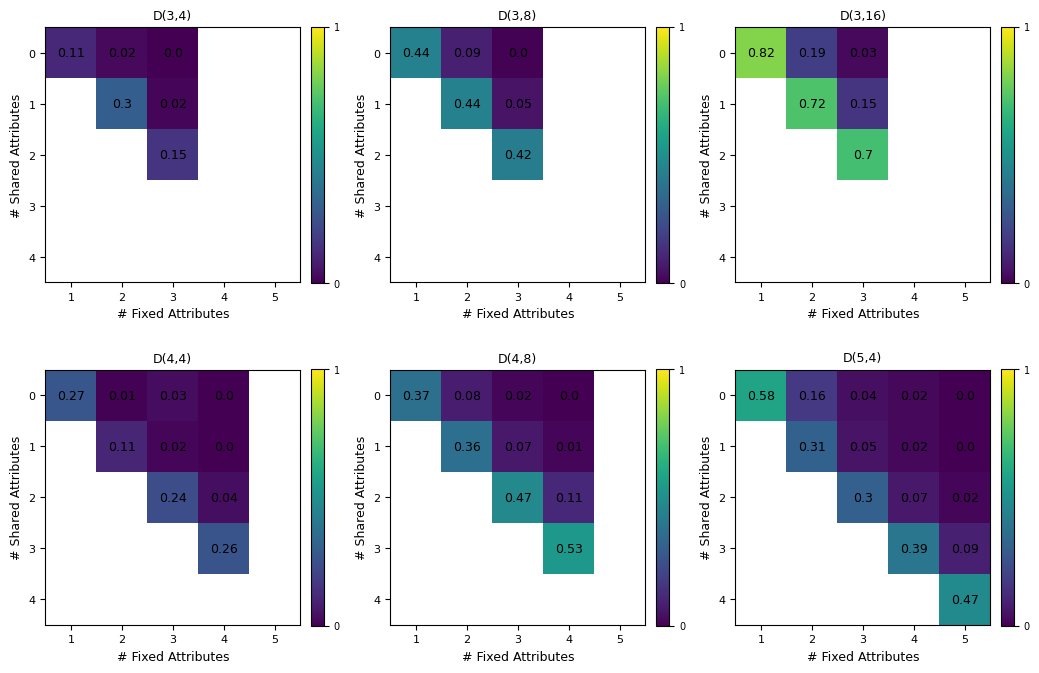

In [104]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

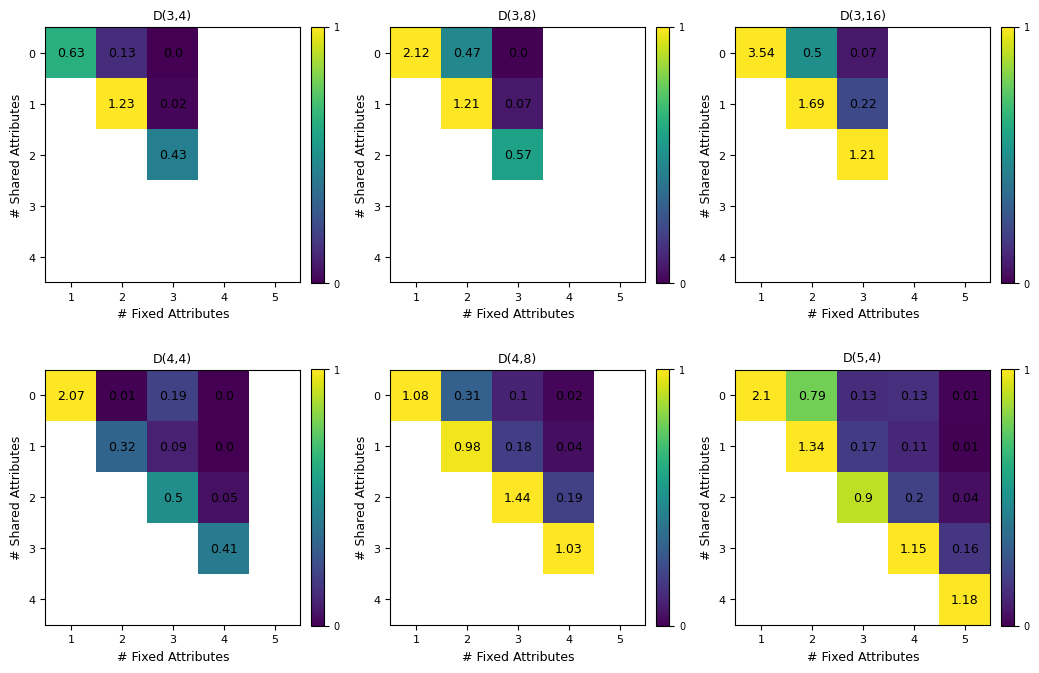

In [204]:
plot_heatmap_concept_x_context_errors(false_objects_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

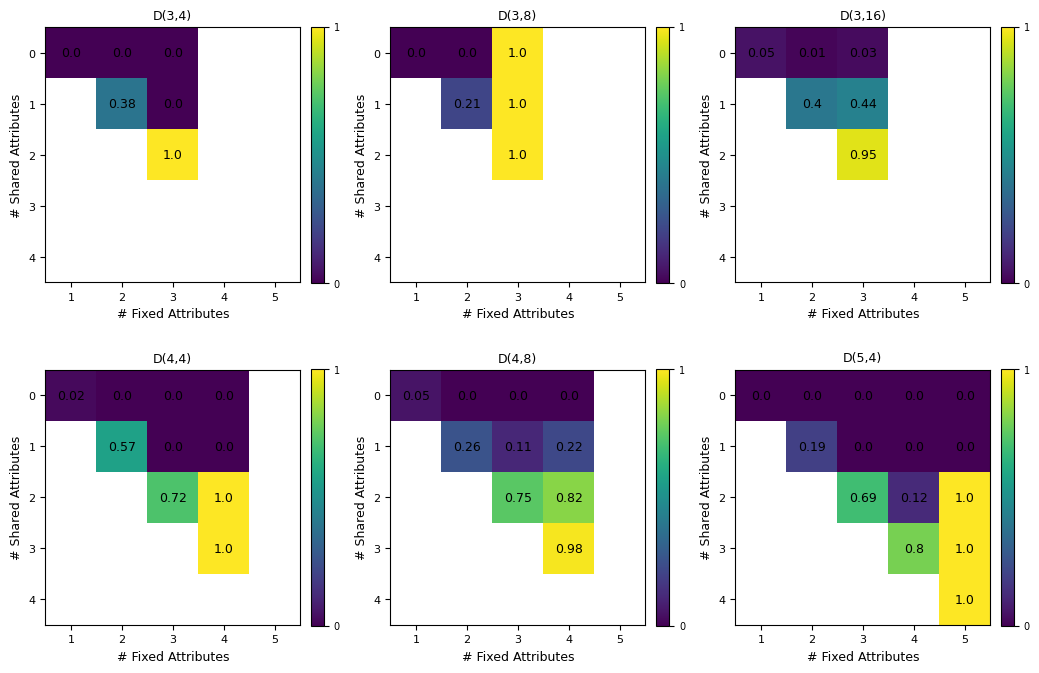

In [196]:
plot_heatmap_concept_x_context_errors(false_positives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

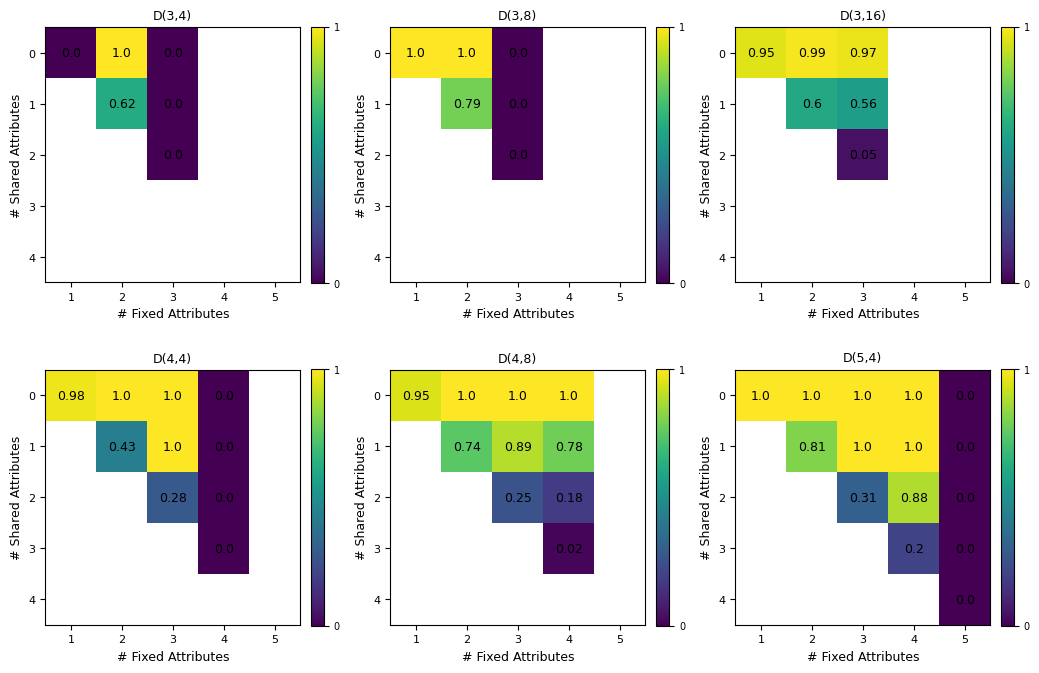

In [197]:
plot_heatmap_concept_x_context_errors(false_negatives_ratio, ylims=(0, 1.0), heatmap_size=(5,5), 
                                figsize=(10.5, 7), fontsize = 9)

In [210]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
# objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)] # 1.79
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0)] # 2.58
objects = [(2, 1, 0,), (2, 0, 1), (2, 2, 2), (1, 1, 1), (0, 1, 0), (1, 0, 0)] # 2.58

# 1. Bestimme die Häufigkeit jedes einzigartigen Objekts in der Liste
object_counts = Counter(objects)

# 2. Berechne die relative Häufigkeit jedes Objekts
total_objects = len(objects)
object_probabilities = {obj: count / total_objects for obj, count in object_counts.items()}

# 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
entropy = -sum(prob * np.log2(prob) for prob in object_probabilities.values())

# Ausgabe der berechneten Entropie
print("Die berechnete Entropie beträgt:", entropy)

Die berechnete Entropie beträgt: 2.584962500721156


In [206]:
import numpy as np
from collections import Counter

# Gegebene Liste von Objekten
objects = [(2, 1, 0,), (2, 1, 0), (2, 1, 0), (2, 1, 1), (0, 1, 0), (2, 0, 0)]

# Transpose the list of objects to get attributes as columns
attributes = np.array(objects).T

# Initialize a list to store the entropy for each attribute
attribute_entropy = []

# Calculate entropy for each attribute
for attribute_values in attributes:
    # 1. Bestimme die Häufigkeit jedes einzigartigen Werts in der Liste
    attribute_counts = Counter(attribute_values)
    
    # 2. Berechne die relative Häufigkeit jedes Werts
    total_values = len(attribute_values)
    value_probabilities = {value: count / total_values for value, count in attribute_counts.items()}
    
    # 3. Verwende die Formel für die Entropie, um die Entropie zu berechnen
    entropy = -sum(prob * np.log2(prob) for prob in value_probabilities.values() if prob != 0)
    
    attribute_entropy.append(entropy)

# Ausgabe der berechneten Entropie für jedes Attribut
print("Die berechnete Entropie für jedes Attribut beträgt:", attribute_entropy)

Die berechnete Entropie für jedes Attribut beträgt: [0.6500224216483541, 0.6500224216483541, 0.6500224216483541]


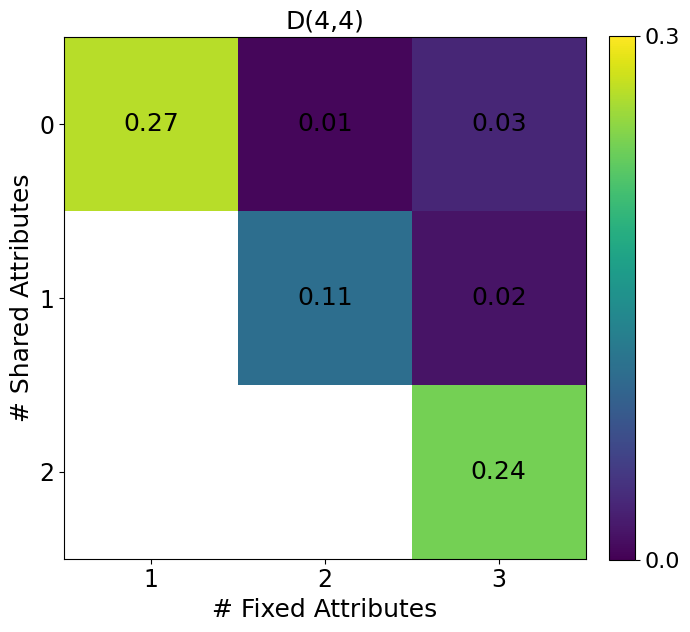

In [211]:
plot_heatmap_concept_x_context_errors(err_ratio_concept_x_context['(4,4)'], one_dataset=True, attributes=4, titles=('D(4,4)',), ylims=(0, 0.3), plot_dims=(1, 1))

## co-occurrences (not done yet)

In [ ]:
# Not done (yet)
full_plot = False

fig = plt.figure(figsize=(12,3))

for d, dim in enumerate(datasets): 
    
    data = datasets[d]
    path = paths[d]
    vs_factor = int(path[-2])
    vocab_size = (n_values[d] + 1) * vs_factor + 1
    colors = plt.cm.jet(np.linspace(0,1,vocab_size))
    
    average_cooccurences = []
    
    plt.subplot(1,6,d+1)
    
    for run in range(5):
        
        cooccurences = pickle.load(open(paths[d] + 'standard/' + str(run) + '/normalized_cooccurrence.pkl', 'rb'))
        indices = np.flip(np.argsort(cooccurences[:,-1]))
        cooccurences = cooccurences[indices]
        average_cooccurences.append(cooccurences)
        
    average_cooccurences = np.flip(np.mean(average_cooccurences, axis=0), axis=1)
    
    data_dict = {}
    data_dict['symbol rank'] = []
    data_dict['level'] = []
    data_dict['value'] = []
    for symbol in indices:
        for level in range(average_cooccurences.shape[1]):
            data_dict['symbol rank'].append(symbol+1)
            data_dict['level'].append(level)
            data_dict['value'].append(average_cooccurences[symbol, level])
    
    if full_plot:
        g = sns.heatmap(average_cooccurences, cmap='viridis')
        plt.yticks(ticks=[0.5,vocab_size-1.5], labels=[1,vocab_size], fontsize=14)
    else: 
        g = sns.heatmap(average_cooccurences[0:10,:], cmap='viridis')
        plt.yticks(ticks=[0.5,9.5], labels=[1,10], fontsize=14, rotation=0)
    cax = plt.gcf().axes[-1]
    cax.tick_params(labelsize=13)
    for _, spine in g.spines.items():
        spine.set_visible(True)
    #plt.xlabel('# relevant attributes', fontsize=14)
    #plt.ylabel('symbol rank', fontsize=14)
    plt.xticks(ticks=np.arange(n_attributes[d])+0.5, labels=range(1,n_attributes[d]+1), fontsize=14)
    plt.title(data, fontsize=14)
    
    fig.text(0.5, -0.05, '# relevant attributes', ha='center', va='center', fontsize=15, alpha=0.3)
    fig.text(-0.01, 0.5, 'symbol rank', ha='center', va='center', rotation='vertical', fontsize=15, alpha=0.3)

plt.tight_layout()